<hr>
<h1><b>Coursework 1:</b></h1>
<h3><i>Submitted for the partial fulfilment of the DSM150 course</i></h3>
<h3><i>By Hendrik Matthys van Rooyen</i></h3>
<h3><i>230221176</i></h3>

<hr>

# **DLWP Flow: MedMNIST - OCTMINST**

<hr>

## Introduction

For this coursework the instructions followed were as follows:
...


### The Dataset
In preparation for this coursework, many datasets were considered, amongst them:
- Anemia Classification
- Back-order Prediction
- Heart Attack Risk Prediction
- IMDB Reccomender
- Text Generation using a corpus

Of these the Anemia and IMDB provided simple models, with minimal opportunity to satisfy the requirements for the Coursework. Both the Back-order and Heart Attack risk provided very poor quality models, barely out-preforming the baseline models. The Text Recommendation, although an interesting project does not fall into the scope of the project, and was infeasible to achieve within the Coursework limitations on the available hardware.

All this considered, the octmnist dataset form the MedMNIST library has provided ample opportunity to explore the data, balance the datasets, and leaves room for improvement on top of a basic neural network.
While the simple Neural networks like these aren't normally considered for image classification, as opposed to CNN's, the DLWP book showed some success in the classification of the normal MNIST dataset, and this one was also considdered for that reason.

<hr>

## Prepare Environment

### Load Packages

In [1]:
import medmnist
from medmnist import INFO, Evaluator

import pandas as pd
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint

### Load Dataset

In [2]:
data_flag = 'octmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])

In [3]:
info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'task': 'multi-class',
 'label': {'0': 'choroidal neovascularization',
  '1': 'diabetic macular edema',
  '2': 'drusen',
  '3': 'normal'},
 'n_channels': 1,
 'n_samples': {'train': 97477, 'val': 10832, 'test': 1000},
 'license': 'CC BY 4.0'}

In [4]:
DataClass = getattr(medmnist, info['python_class'])

# Load each split
train_data = DataClass(split='train', download=True)
val_data = DataClass(split='val', download=True)
test_data = DataClass(split='test', download=True)

Using downloaded and verified file: C:\Users\mvanr\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\mvanr\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\mvanr\.medmnist\octmnist.npz


<hr>

## Investigate Dataset

In investigating the dataset, we inspect both samples from the data, to determine if there may be any notable differences or similarities between entries, which could inform the design of the network or the handling of the data.
We also investigate the distribution of the entries across classes.

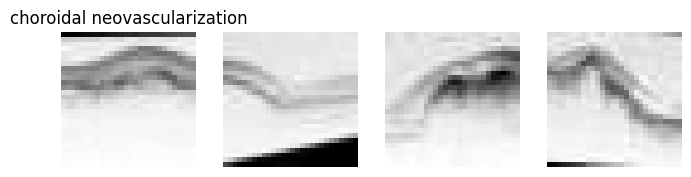

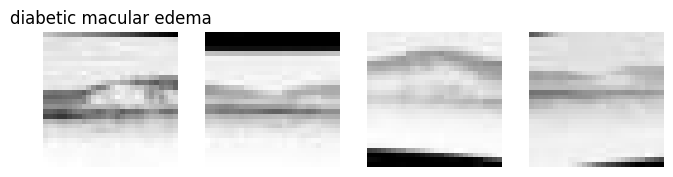

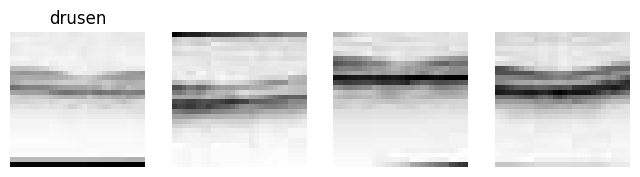

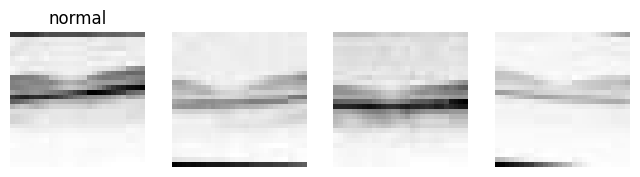

In [5]:
import matplotlib.pyplot as plt

def display_images_with_label(images, labels, info, target_label, num_images, seed=None):
    # Set the random seed if provided.
    if seed is not None:
        np.random.seed(seed)
        
    # Ensure the labels are numpy arrays for boolean indexing.
    labels = np.array(labels)
    images = np.array(images)
    
    # Find the indices of all images that match the target label.
    matching_indices = np.where(labels == target_label)[0]
    
    # Select a random subset of these indices.
    if len(matching_indices) >= num_images:
        selected_indices = np.random.choice(matching_indices, size=num_images, replace=False)
    else:
        selected_indices = matching_indices  # If there aren't enough, select them all.
    
    # Set up the plot size.
    plt.figure(figsize=(2 * num_images, 2))  # You can adjust the figure size as needed.
    
    # Create a subplot for each selected image.
    for i, index in enumerate(selected_indices, 1):
        ax = plt.subplot(1, num_images, i)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.axis('off')  # Hide the axis to put more focus on the images.
        # Set the title for the first image only.
        if i == 1:
            ax.set_title(f'{info["label"][str(target_label)]}')
    
    plt.show()
    
display_images_with_label(test_data.imgs,test_data.labels,info,0,4,42)
display_images_with_label(test_data.imgs,test_data.labels,info,1,4,42)
display_images_with_label(test_data.imgs,test_data.labels,info,2,4,42)
display_images_with_label(test_data.imgs,test_data.labels,info,3,4,42)

From the samples above, a challenge that will form a larger theme in the project becomes apparent; that being, the similarity between the drusen and the normal images.

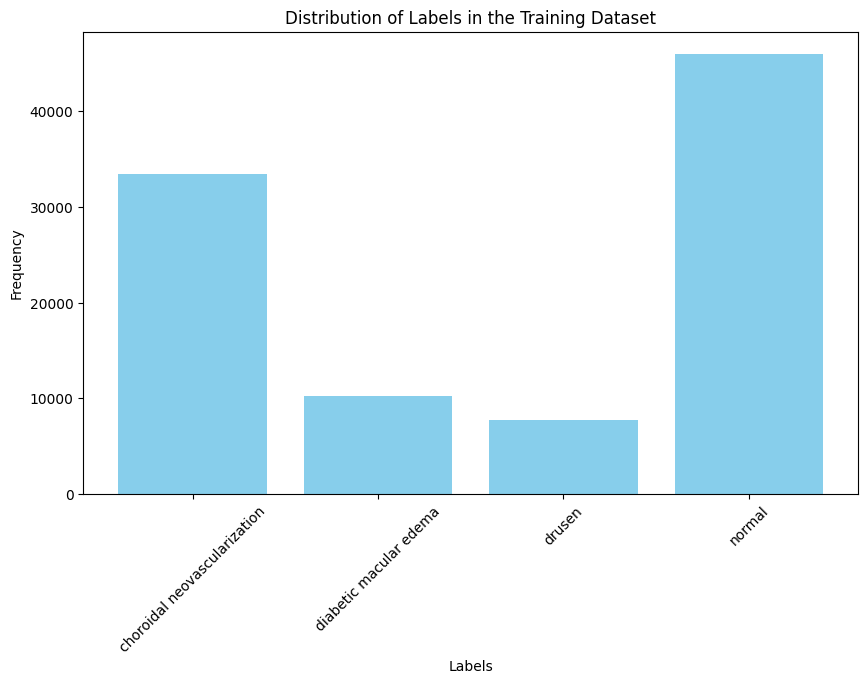

In [6]:
import matplotlib.pyplot as plt

unique_labels, counts = np.unique(train_data.labels, return_counts=True)
label_names = [info['label'][str(label)] for label in unique_labels]

# Plotting the distribution of labels
plt.figure(figsize=(10, 6))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Training Dataset')
plt.xticks(rotation=45)
plt.show()

The above graph shows a large inequality between entries per label, with normal being the most, and drusen being the least. This increases the problem of the classifications being very similar.

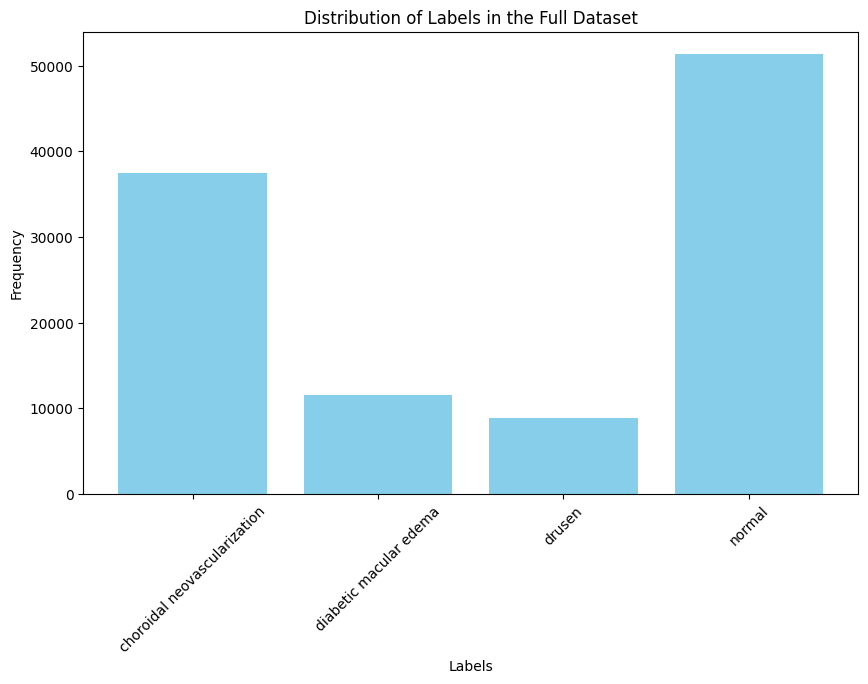

In [7]:
import matplotlib.pyplot as plt

unique_labels, counts = np.unique(np.concatenate((train_data.labels, val_data.labels, test_data.labels), axis=0), return_counts=True)
label_names = [info['label'][str(label)] for label in unique_labels]

# Plotting the distribution of labels
plt.figure(figsize=(10, 6))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Full Dataset')
plt.xticks(rotation=45)
plt.show()

<hr>

## Prepare Data

In preparation of training the network we compute the class weight of each label in order to experiment with balancing the importance in training.

In order to balance the classes we augment the images of classes with lower representation.

The image pixel values, which is normally between 5 and 255 is finally divided by 255 in order to normalize the values between 0 and 1

In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.labels.flatten()),
    y=train_data.labels.flatten()
)

class_weight_dict = dict(enumerate(class_weights / 4))
class_weight_dict

{0: 0.18194697467447138,
 1: 0.596525261921081,
 2: 0.7856993164818158,
 3: 0.13236676009212184}

In [9]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

def augment_images_to_balance_classes(images, labels, batch_size, seed):
    
    images = images.reshape((-1, 28, 28, 1))
    
    # Find the label with the most entries
    (unique, counts) = np.unique(labels, return_counts=True)
    max_count = np.max(counts)
    class_indices = {label: np.where(labels == label)[0] for label in unique}
    max_label = unique[np.argmax(counts)]

    # Initialize the image data generator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Seed for reproducibility
    np.random.seed(seed)

    # Initialize lists for the balanced dataset
    balanced_images = list(images)
    balanced_labels = list(labels)

    # Augment data for classes with fewer images than the max_count
    for label, indices in class_indices.items():
        if label == max_label:
            continue  # Skip the class with the most samples
        num_to_augment = max_count - counts[unique.tolist().index(label)]
        
        # Augment images until the class has the same number of images as the max_count
        augmentation_factor = int(np.ceil(num_to_augment / len(indices)))
        for i in range(augmentation_factor):
            for index in indices:
                image_to_augment = images[index].reshape((1, *images[index].shape))
                iterator = datagen.flow(image_to_augment, batch_size=1, seed=seed)
                for _ in range(min(num_to_augment, batch_size)):
                    augmented_image = next(iterator)[0].astype('uint8')
                    balanced_images.append(augmented_image)
                    balanced_labels.append(label)
                    num_to_augment -= 1
                    if num_to_augment <= 0:
                        break
                if num_to_augment <= 0:
                    break

    return np.array(balanced_images), np.array(balanced_labels)


In [10]:
train_images, train_labels = augment_images_to_balance_classes(train_data.imgs, train_data.labels.flatten(), batch_size=32, seed=42)
train_images = train_images / 255.0

val_images = val_data.imgs / 255.0
val_labels = val_data.labels

test_images = test_data.imgs / 255.0
test_labels = test_data.labels

print('tensor shape:')
print('\ttraining images:', train_images.shape)
print('\ttraining labels:', train_labels.shape)
print('\tvalidation images:', val_images.shape)
print('\tvalidation images:', val_labels.shape)
print('\ttesting images:', test_images.shape)
print('\ttesting images:', test_labels.shape)

tensor shape:
	training images: (184104, 28, 28, 1)
	training labels: (184104,)
	validation images: (10832, 28, 28)
	validation images: (10832, 1)
	testing images: (1000, 28, 28)
	testing images: (1000, 1)


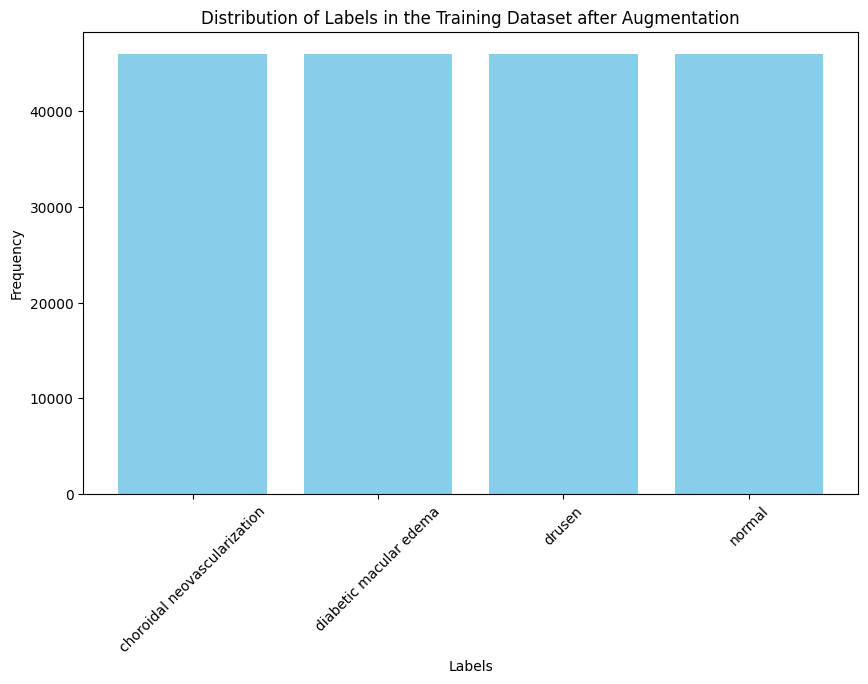

In [11]:
import matplotlib.pyplot as plt

unique_labels, counts = np.unique(train_labels, return_counts=True)
label_names = [info['label'][str(label)] for label in unique_labels]

# Plotting the distribution of labels
plt.figure(figsize=(10, 6))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Training Dataset after Augmentation')
plt.xticks(rotation=45)
plt.show()

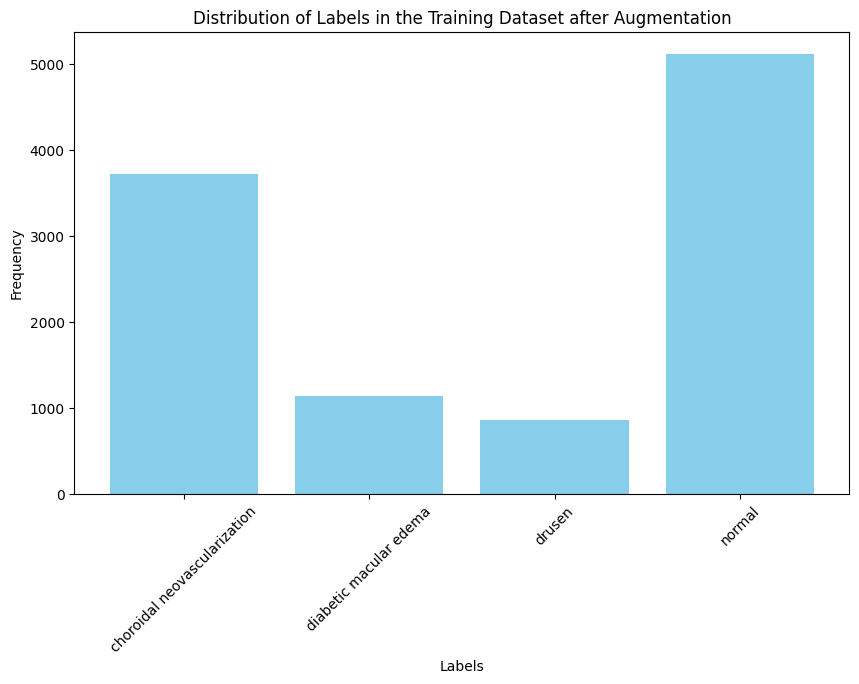

In [12]:
import matplotlib.pyplot as plt

unique_labels, counts = np.unique(val_labels, return_counts=True)
label_names = [info['label'][str(label)] for label in unique_labels]

# Plotting the distribution of labels
plt.figure(figsize=(10, 6))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Training Dataset after Augmentation')
plt.xticks(rotation=45)
plt.show()

Above it is shown that the labels is  now balanced after the augmentation.

In [12]:
# Flatten images if they are not already 1D
if len(train_images.shape) > 2:
    # Flatten the image data to 1D (number of samples, image_width * image_height * channels)
    train_images = train_images.reshape((len(train_images), 28*28))
    val_images = val_images.reshape((10832, 28*28))
    test_images = test_images.reshape((1000, 28*28))

In [13]:
from tensorflow.keras.utils import to_categorical

original_label = test_labels[0]
#train_labels = to_categorical(train_labels)
#test_labels = to_categorical(test_labels)
#val_labels = to_categorical(val_labels)

print('\'',original_label, '\'')
print(test_labels[0])

' [3] '
[3]


## Building the network

In [14]:
info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'task': 'multi-class',
 'label': {'0': 'choroidal neovascularization',
  '1': 'diabetic macular edema',
  '2': 'drusen',
  '3': 'normal'},
 'n_channels': 1,
 'n_samples': {'train': 97477, 'val': 10832, 'test': 1000},
 'license': 'CC BY 4.0'}

In [15]:
train_labels.shape

(184104,)

In [16]:
from sklearn.utils.class_weight import compute_class_weight

# classes should be a list of unique labels in the dataset.
# y_train should be a list/array of your training labels.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels.flatten()),
    y=train_labels.flatten()
)

class_weight_dict = dict(enumerate(class_weights))

In [17]:
class_weight_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [18]:
class_weight_dict[2] += class_weight_dict[2]*1.8

In [19]:
class_weight_dict = {0: 1.0,1: 1.0, 2:1.0,3:1.0}

In [20]:
class_weight_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

## Training the network

Helper functions is defined in order to display the model performance after training in order to evaluate the outcomes of hyperparameter tuning and network structure changes.

Checkpoints is created at each optimal epoch in order to effectively evaluate performance, and save time from having to re-run model training.

In [20]:
from tensorflow.keras.models import load_model

def plot_epochs(x,
                y_A, style_A, label_A,
                y_B, style_B, label_B,
                title, x_label, y_label):
    import matplotlib.pyplot as plt
    plt.clf()
    plt.plot(x,y_A, style_A, label = label_A)
    plt.plot(x,y_B, style_B, label = label_B)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

def plot_network_summaries(history, optimal_model = None, test_images = None, test_labels = None ):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_epochs(
        range(1, len(loss) + 1),
        loss, 'bo', 'Training',
        val_loss, 'b', 'Validation',
        'Training and validation loss',
        'Epochs',
        'Loss'
    )

    plot_epochs(
        range(1, len(loss) + 1),
        acc, 'bo', 'Training',
        val_acc, 'b', 'Validation',
        'Training and validation accuracy',
        'Epochs',
        'Accuracy'
    )
    
    print('Optimal point: ', np.argmin(val_loss)+1, 'epochs')
    
    if optimal_model is None:
        return
    
    network = load_model(optimal_model)
    probabilities = network.predict(test_images)
    predicted_classes = np.argmax(probabilities, axis=1)

    true_classes = test_labels.flatten()

    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Generate the confusion matrix
    labels = [info['label'][str(label)] for label in range(n_classes)]
    cm = confusion_matrix(true_classes, predicted_classes.flatten())

    # If you want to have a DataFrame representation
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.xticks(rotation=45)
    plt.show()
    
    test_loss, test_acc = network.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc)

### Network A

This fist model has been left for reference, as it was trained prior to the balancing of the labels through augmentation.

The code for balancing is also still present, but was later moved to the data preparation stage.

In [60]:
from tensorflow.keras import models, layers

class_weight_dict = {0: 1.0,1: 1.0, 2:1.0,3:1.0}

checkpoint = ModelCheckpoint(
    'best_model_A.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=25, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/25
1439/1439 [==============================] - 5s 3ms/step - loss: 1.1059 - accuracy: 0.5091 - val_loss: 0.9769 - val_accuracy: 0.6251
Epoch 2/25
1439/1439 [==============================] - 5s 3ms/step - loss: 0.9600 - accuracy: 0.5969 - val_loss: 0.9124 - val_accuracy: 0.6350
Epoch 3/25
1439/1439 [==============================] - 5s 3ms/step - loss: 0.8895 - accuracy: 0.6327 - val_loss: 0.8386 - val_accuracy: 0.6753
Epoch 4/25
1439/1439 [==============================] - 5s 3ms/step - loss: 0.8473 - accuracy: 0.6555 - val_loss: 0.7633 - val_accuracy: 0.7324
Epoch 5/25
1439/1439 [==============================] - 5s 3ms/step - loss: 0.8130 - accuracy: 0.6719 - val_loss: 0.7707 - val_accuracy: 0.7156
Epoch 6/25
1439/1439 [==============================] - 5s 3ms/step - loss: 0.7888 - accuracy: 0.6848 - val_loss: 0.7031 - val_accuracy: 0.7425
Epoch 7/25
1439/1439 [==============================] - 5s 3ms/step - loss: 0.7681 - accuracy: 0.6934 - val_loss: 0.7001 - val_accuracy:

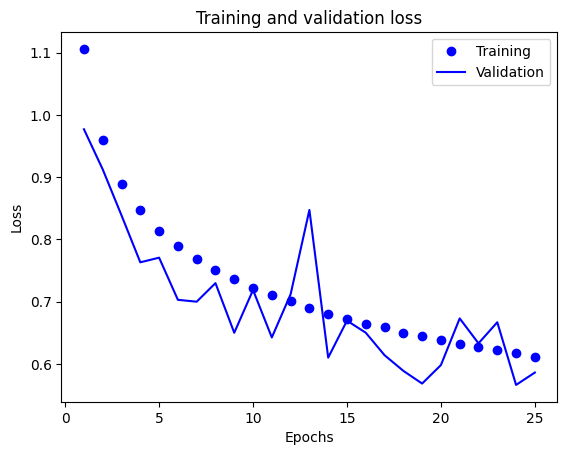

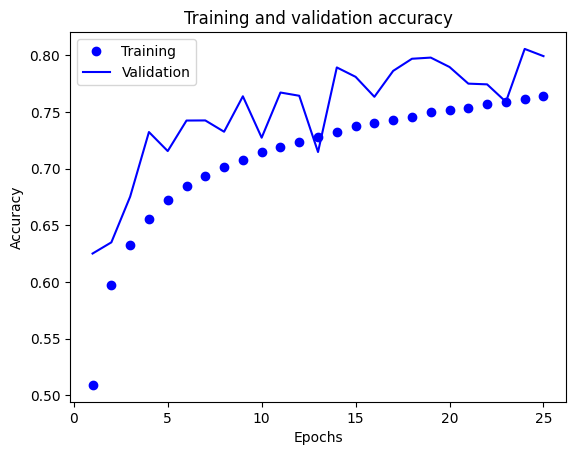

Optimal point:  23 epochs
339/339 [==============================] - 1s 1ms/step


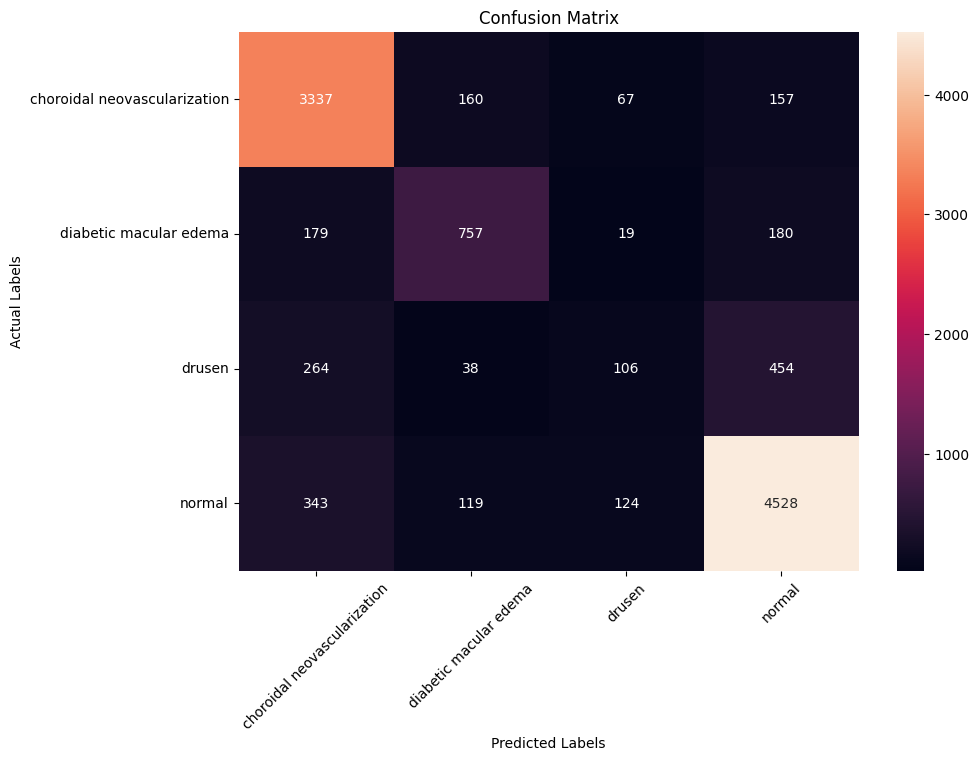

339/339 [==============================] - 1s 2ms/step - loss: 0.5664 - accuracy: 0.8058
Test accuracy: 0.8057606816291809


In [64]:
plot_network_summaries(history, 'best_model_A.hdf5', val_images, val_labels)

From the above we can see that the model at the optimal point results in an .8 accuracy, which is a good start, however, it is also clear that the drusen label is much less accurate.

Having an unbalanced validation set (as provided by the `medmnist` library) does not provide a reliable indication of performance.

This, combined with the similarity between drusen and normal would cause a very inaccurate final test.

### Reload and balance the dataset

In [15]:
DataClass = getattr(medmnist, info['python_class'])

# Load each split
train_data = DataClass(split='train', download=True)
val_data = DataClass(split='val', download=True)

import numpy as np
from sklearn.model_selection import train_test_split

# Combine the datasets
all_imgs = np.concatenate((train_data.imgs, val_data.imgs), axis=0)
all_labels = np.concatenate((train_data.labels, val_data.labels), axis=0)

# Shuffle the dataset
permutation = np.random.permutation(len(all_labels))
shuffled_imgs = all_imgs[permutation]
shuffled_labels = all_labels[permutation]

# Define the number of samples per label for the validation set
validation_count_per_label = 750
unique_labels = [0, 1, 2, 3]  # Defined set of unique labels

# Initialize lists to hold the split data
validation_imgs = []
validation_labels = []
train_imgs = []
train_labels = []

for label in unique_labels:
    label_indices = np.where(shuffled_labels == label)[0]
    
    # Check if there are enough samples for the label
    if len(label_indices) < validation_count_per_label:
        raise ValueError(f"Not enough samples for label {label}.")
    
    validation_indices = label_indices[:validation_count_per_label]
    train_indices = label_indices[validation_count_per_label:]
    
    validation_imgs.append(shuffled_imgs[validation_indices])
    validation_labels.append(shuffled_labels[validation_indices])
    
    train_imgs.append(shuffled_imgs[train_indices])
    train_labels.append(shuffled_labels[train_indices])

# Reassemble the training and validation sets
train_imgs = np.concatenate(train_imgs, axis=0)
train_labels = np.concatenate(train_labels, axis=0)
validation_imgs = np.concatenate(validation_imgs, axis=0)
validation_labels = np.concatenate(validation_labels, axis=0)

Using downloaded and verified file: C:\Users\mvanr\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\mvanr\.medmnist\octmnist.npz


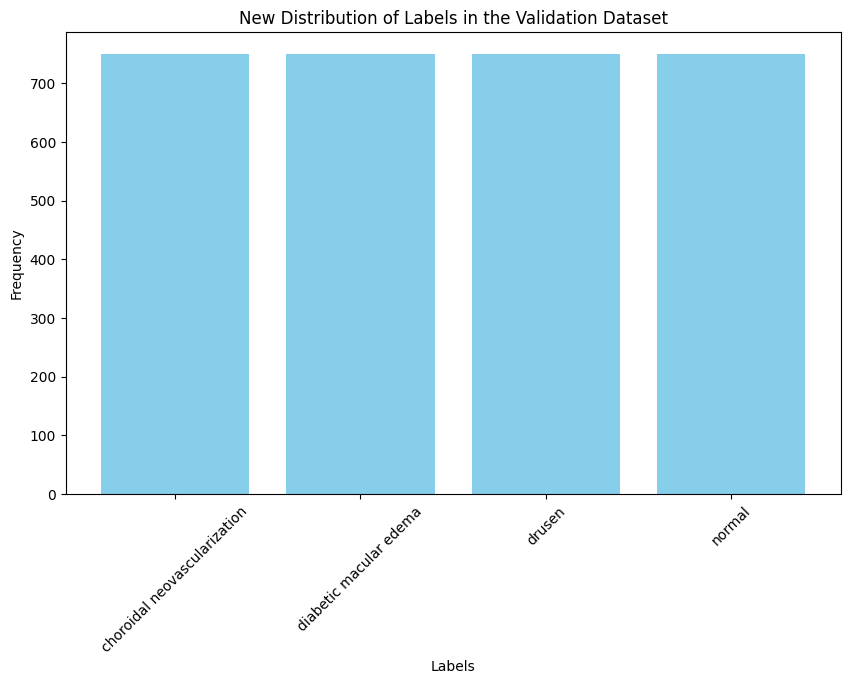

In [16]:
import matplotlib.pyplot as plt

unique_labels, counts = np.unique(validation_labels, return_counts=True)
label_names = [info['label'][str(label)] for label in unique_labels]

# Plotting the distribution of labels
plt.figure(figsize=(10, 6))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('New Distribution of Labels in the Validation Dataset')
plt.xticks(rotation=45)
plt.show()

In [17]:
train_images, train_labels = augment_images_to_balance_classes(train_imgs, train_labels.flatten(), batch_size=32, seed=42)
train_images = train_images / 255.0

val_images = validation_imgs / 255.0
val_labels = validation_labels

In [18]:
train_images = train_images.reshape((len(train_images), 28*28))
val_images = val_images.reshape((len(val_images), 28*28))

### Rerun initial training on rebalanced data

The initial training is re-done on the balanced dataset.

In [96]:
from tensorflow.keras import models, layers

class_weight_dict = {0: 1.0,1: 1.0, 2:1.0,3:1.0}

checkpoint = ModelCheckpoint(
    'best_model_A.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=25, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/25
1575/1575 [==============================] - 5s 3ms/step - loss: 1.0901 - accuracy: 0.5191 - val_loss: 1.2743 - val_accuracy: 0.4537
Epoch 2/25
  47/1575 [..............................] - ETA: 5s - loss: 0.9853 - accuracy: 0.5836

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1575/1575 [==============================] - 5s 3ms/step - loss: 0.9377 - accuracy: 0.6096 - val_loss: 1.2898 - val_accuracy: 0.5053
Epoch 3/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.8661 - accuracy: 0.6445 - val_loss: 1.2058 - val_accuracy: 0.5437
Epoch 4/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.8238 - accuracy: 0.6670 - val_loss: 0.9648 - val_accuracy: 0.5910
Epoch 5/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.7930 - accuracy: 0.6824 - val_loss: 1.0018 - val_accuracy: 0.5837
Epoch 6/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.7685 - accuracy: 0.6939 - val_loss: 0.9446 - val_accuracy: 0.6123
Epoch 7/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.7482 - accuracy: 0.7033 - val_loss: 1.0299 - val_accuracy: 0.6000
Epoch 8/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.7329 - accuracy: 0.7111 - val_loss: 1.1116 - val_accuracy: 0.5720
Epo

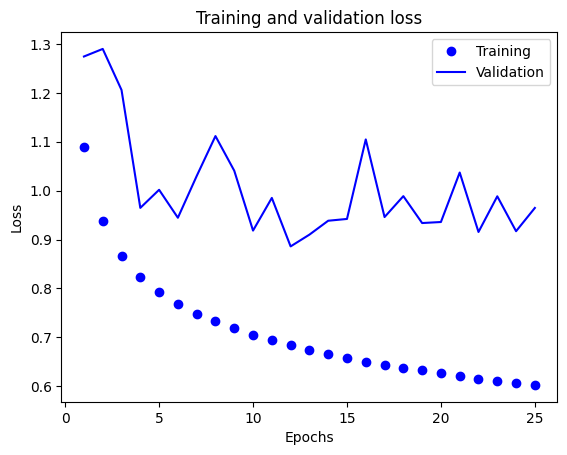

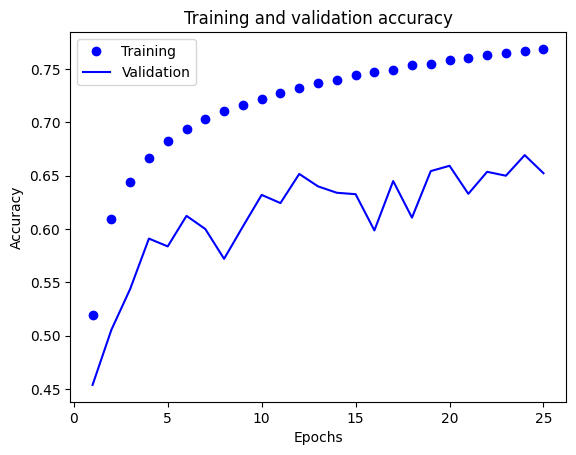

Optimal point:  11 epochs
94/94 [==============================] - 0s 1ms/step


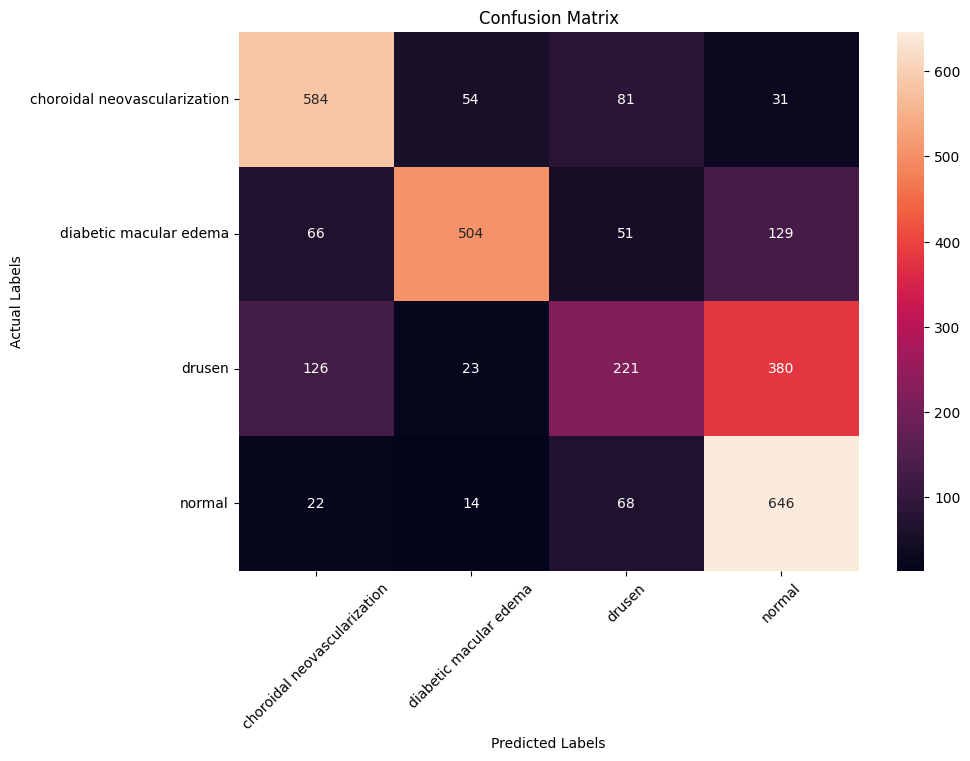

94/94 [==============================] - 0s 2ms/step - loss: 0.8860 - accuracy: 0.6517
Test accuracy: 0.6516666412353516


In [97]:
plot_network_summaries(history, 'best_model_A.hdf5', val_images, val_labels)

From the above, we can see that the drusen label still under-performs, but this is now also correctly reflected in the accuracy

#### Network A1 - Adam optimizer

The optimizer is changed to the "Adam" optimizer, resulting in some accuracy gain while the rest of the network stays constant.

In [99]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model_A1.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

class_weight_dict = {0: 1.0,1: 1.0, 2:1.0,3:1.0}

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=25, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/25
1575/1575 [==============================] - 6s 3ms/step - loss: 1.0616 - accuracy: 0.5352 - val_loss: 1.2005 - val_accuracy: 0.4893
Epoch 2/25
  31/1575 [..............................] - ETA: 5s - loss: 0.9705 - accuracy: 0.5905

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1575/1575 [==============================] - 5s 3ms/step - loss: 0.9107 - accuracy: 0.6216 - val_loss: 1.0246 - val_accuracy: 0.5607
Epoch 3/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.8432 - accuracy: 0.6561 - val_loss: 1.1047 - val_accuracy: 0.5610
Epoch 4/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.8035 - accuracy: 0.6761 - val_loss: 0.9832 - val_accuracy: 0.5857
Epoch 5/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.7743 - accuracy: 0.6892 - val_loss: 1.0746 - val_accuracy: 0.5710
Epoch 6/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.7526 - accuracy: 0.7003 - val_loss: 0.9447 - val_accuracy: 0.6100
Epoch 7/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.7336 - accuracy: 0.7086 - val_loss: 0.9457 - val_accuracy: 0.6107
Epoch 8/25
1575/1575 [==============================] - 5s 3ms/step - loss: 0.7159 - accuracy: 0.7158 - val_loss: 0.9243 - val_accuracy: 0.6090
Epo

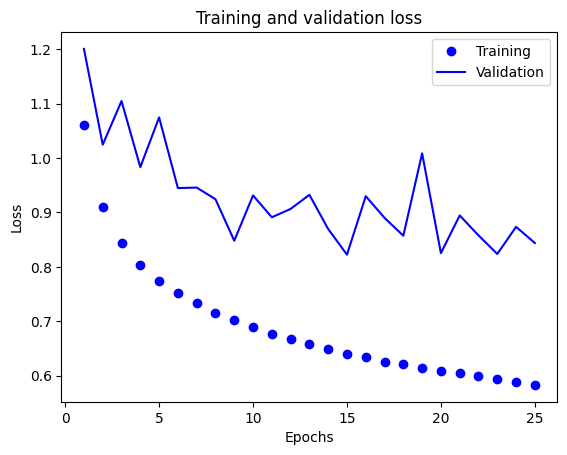

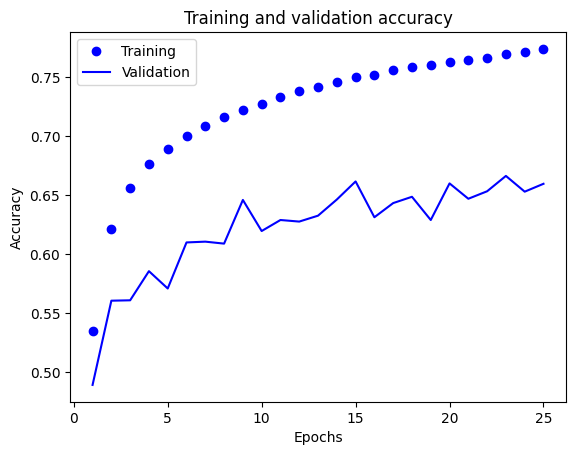

Optimal point:  14 epochs
94/94 [==============================] - 0s 1ms/step


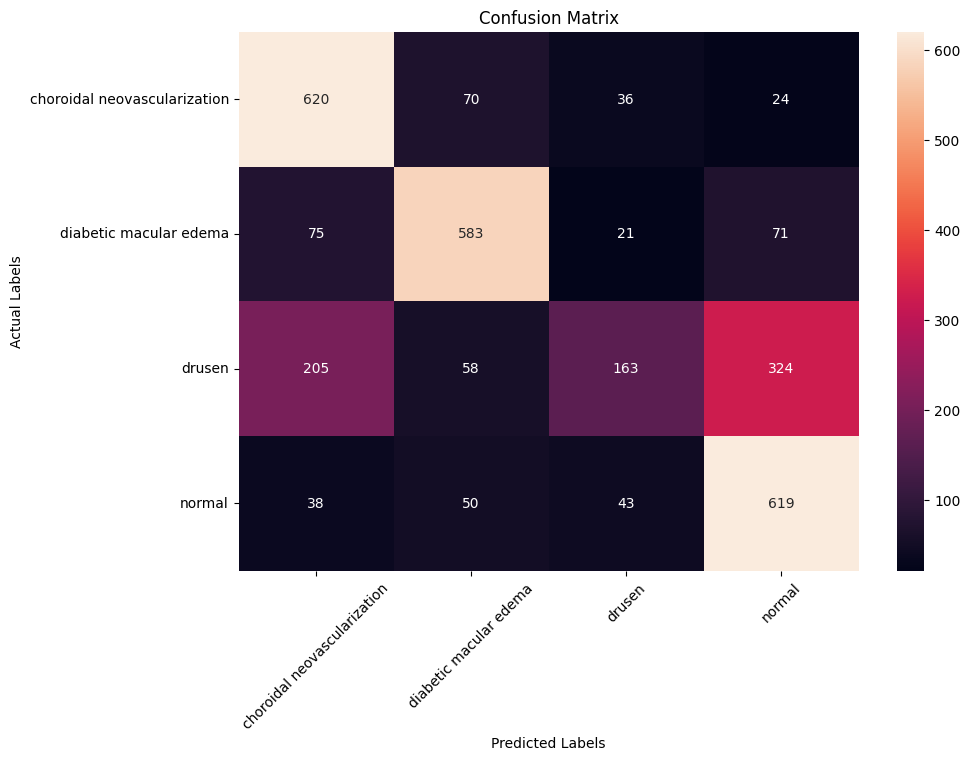

94/94 [==============================] - 0s 1ms/step - loss: 0.8224 - accuracy: 0.6617
Test accuracy: 0.6616666913032532


In [100]:
plot_network_summaries(history, 'best_model_A1.hdf5', val_images, val_labels)

### Network B

A new, deeper network is constructed in order to determine an over-fitted baseline.

This network consists of dense layers with 1024, 512, 256, 64 neurons respectively.

In [103]:
from tensorflow.keras import models, layers

checkpoint = ModelCheckpoint(
    'best_model_B.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(512, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(256, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(64, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=50, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/50
1575/1575 [==============================] - 14s 9ms/step - loss: 1.0325 - accuracy: 0.5440 - val_loss: 1.2274 - val_accuracy: 0.4887
Epoch 2/50
  13/1575 [..............................] - ETA: 13s - loss: 0.9147 - accuracy: 0.6166

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1575/1575 [==============================] - 14s 9ms/step - loss: 0.8553 - accuracy: 0.6451 - val_loss: 1.0513 - val_accuracy: 0.5647
Epoch 3/50
1575/1575 [==============================] - 13s 9ms/step - loss: 0.7802 - accuracy: 0.6816 - val_loss: 1.0006 - val_accuracy: 0.5827
Epoch 4/50
1575/1575 [==============================] - 14s 9ms/step - loss: 0.7341 - accuracy: 0.7035 - val_loss: 0.9759 - val_accuracy: 0.5947
Epoch 5/50
1575/1575 [==============================] - 14s 9ms/step - loss: 0.6995 - accuracy: 0.7208 - val_loss: 0.9221 - val_accuracy: 0.6070
Epoch 6/50
1575/1575 [==============================] - 14s 9ms/step - loss: 0.6736 - accuracy: 0.7313 - val_loss: 1.1278 - val_accuracy: 0.5887
Epoch 7/50
1575/1575 [==============================] - 14s 9ms/step - loss: 0.6496 - accuracy: 0.7431 - val_loss: 0.8857 - val_accuracy: 0.6290
Epoch 8/50
1575/1575 [==============================] - 14s 9ms/step - loss: 0.6272 - accuracy: 0.7517 - val_loss: 0.8575 - val_accuracy: 0.6

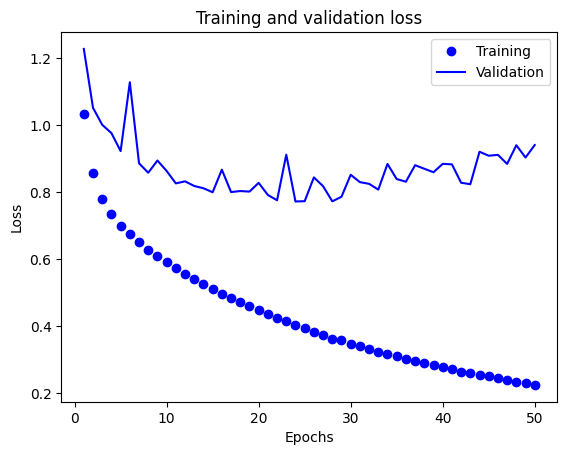

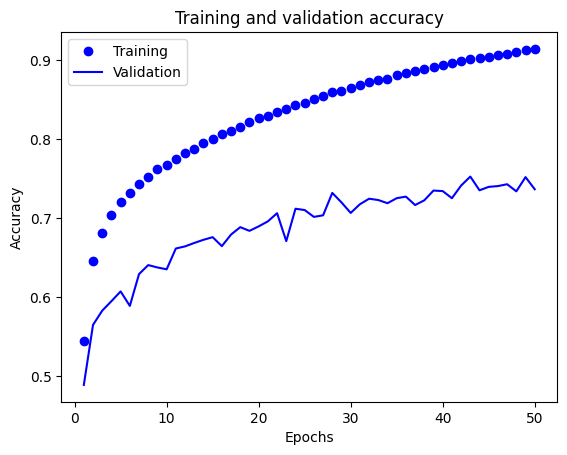

Optimal point:  24 epochs
94/94 [==============================] - 0s 3ms/step


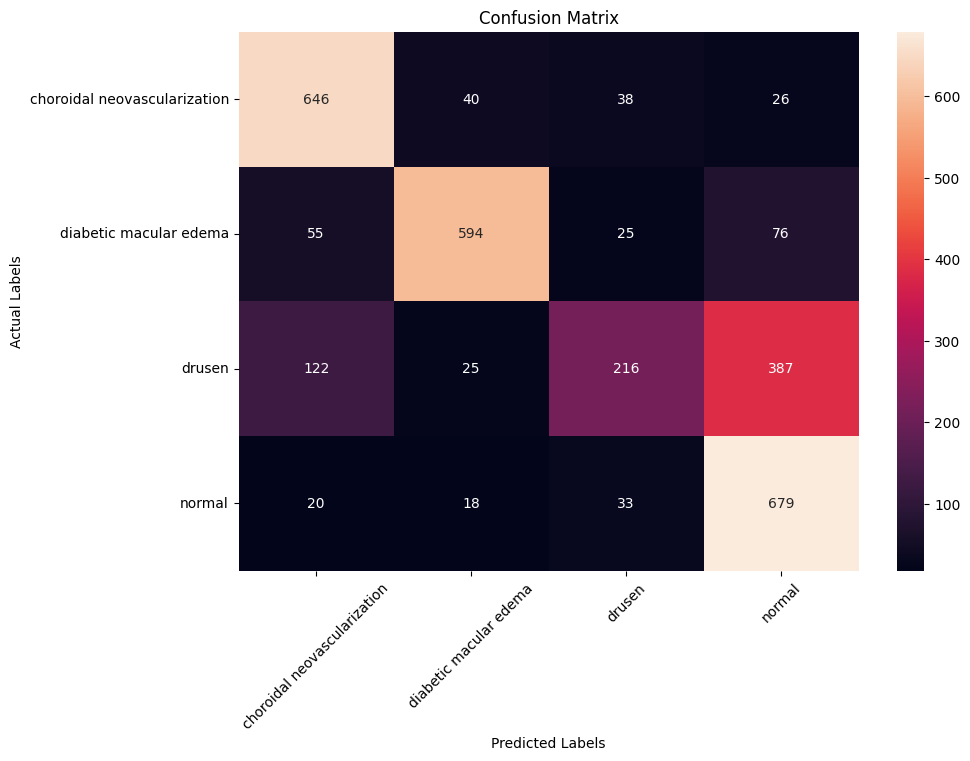

94/94 [==============================] - 0s 3ms/step - loss: 0.7716 - accuracy: 0.7117
Test accuracy: 0.7116666436195374


In [108]:
plot_network_summaries(history, 'best_model_B.hdf5', val_images, val_labels)

This new network improves the accuracy further, but overfits at 24 epochs.

Drusen is still frequently predicted as normal.

#### B1 - Add Dropout

For this iteration of the network a dropout of 0.2 is added to each layer in order to reduce overfiting.

In [21]:
from tensorflow.keras import models, layers

checkpoint = ModelCheckpoint(
    'best_model_B1.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=150, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/150
1573/1575 [============================>.] - ETA: 0s - loss: 0.4369 - accuracy: 0.3745

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1575/1575 [==============================] - 21s 12ms/step - loss: 0.4369 - accuracy: 0.3745 - val_loss: 1.2823 - val_accuracy: 0.4060
Epoch 2/150
1575/1575 [==============================] - 18s 12ms/step - loss: 0.3974 - accuracy: 0.4553 - val_loss: 1.2131 - val_accuracy: 0.4667
Epoch 3/150
1575/1575 [==============================] - 18s 12ms/step - loss: 0.3791 - accuracy: 0.4947 - val_loss: 1.1473 - val_accuracy: 0.5053
Epoch 4/150
1575/1575 [==============================] - 18s 12ms/step - loss: 0.3659 - accuracy: 0.5159 - val_loss: 1.0950 - val_accuracy: 0.5390
Epoch 5/150
1575/1575 [==============================] - 19s 12ms/step - loss: 0.3571 - accuracy: 0.5320 - val_loss: 1.0361 - val_accuracy: 0.5680
Epoch 6/150
1575/1575 [==============================] - 18s 12ms/step - loss: 0.3503 - accuracy: 0.5411 - val_loss: 1.0273 - val_accuracy: 0.5707
Epoch 7/150
1575/1575 [==============================] - 18s 12ms/step - loss: 0.3445 - accuracy: 0.5512 - val_loss: 1.0736 - val_

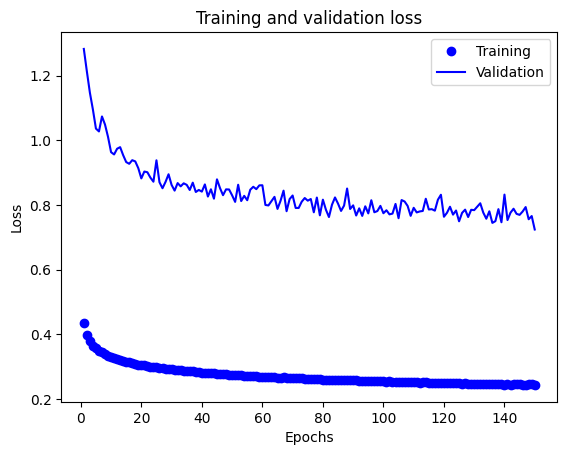

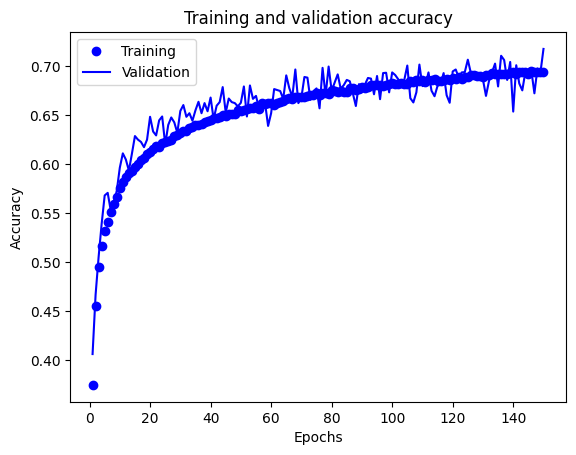

Optimal point:  150 epochs
94/94 [==============================] - 0s 3ms/step


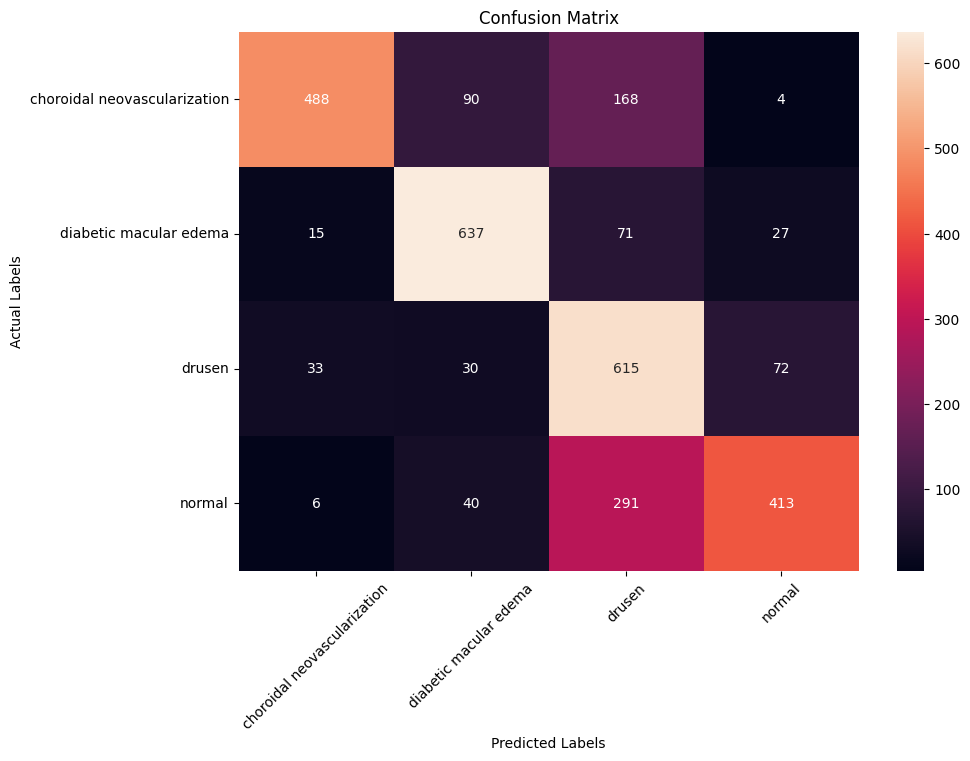

94/94 [==============================] - 0s 3ms/step - loss: 0.7243 - accuracy: 0.7177
Test accuracy: 0.7176666855812073


In [24]:
plot_network_summaries(history, 'best_model_B1.hdf5', val_images, val_labels)

This iteration does not seem to reach a phase of overfitting within 150 epochs, but does not present clear accuracy benefit over that of the "B" model.

This model does however present some benefit in the classification of the drusen label.

#### B2 - No Dropout, with square layers

The dropout is removed, and three layers of 1024 neurons each is used.

In [30]:
from tensorflow.keras import models, layers

checkpoint = ModelCheckpoint(
    'best_model_B1-2.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(1024, activation='relu'))
network.add(layers.Dense(1024, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=50, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/50
1575/1575 [==============================] - 29s 18ms/step - loss: 0.4091 - accuracy: 0.4340 - val_loss: 1.2176 - val_accuracy: 0.4643
Epoch 2/50
   1/1575 [..............................] - ETA: 31s - loss: 0.3991 - accuracy: 0.4219

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1575/1575 [==============================] - 27s 17ms/step - loss: 0.3555 - accuracy: 0.5359 - val_loss: 1.0603 - val_accuracy: 0.5490
Epoch 3/50
1575/1575 [==============================] - 28s 18ms/step - loss: 0.3269 - accuracy: 0.5825 - val_loss: 0.9937 - val_accuracy: 0.5763
Epoch 4/50
1575/1575 [==============================] - 27s 17ms/step - loss: 0.3085 - accuracy: 0.6121 - val_loss: 0.9808 - val_accuracy: 0.5960
Epoch 5/50
1575/1575 [==============================] - 27s 17ms/step - loss: 0.2949 - accuracy: 0.6314 - val_loss: 0.8779 - val_accuracy: 0.6400
Epoch 6/50
1575/1575 [==============================] - 28s 18ms/step - loss: 0.2843 - accuracy: 0.6475 - val_loss: 0.9046 - val_accuracy: 0.6300
Epoch 7/50
1575/1575 [==============================] - 28s 18ms/step - loss: 0.2748 - accuracy: 0.6602 - val_loss: 0.8724 - val_accuracy: 0.6520
Epoch 8/50
1575/1575 [==============================] - 28s 18ms/step - loss: 0.2658 - accuracy: 0.6741 - val_loss: 0.8488 - val_accura

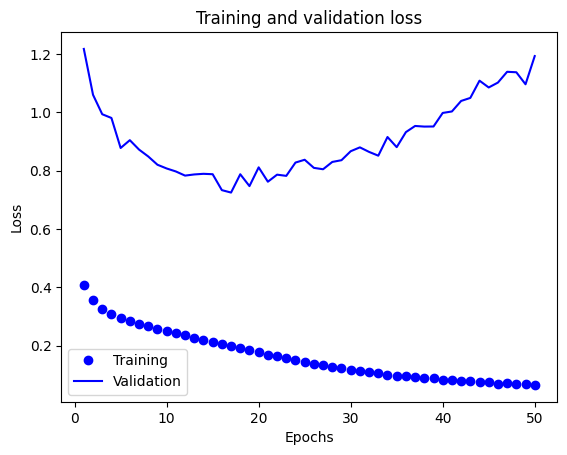

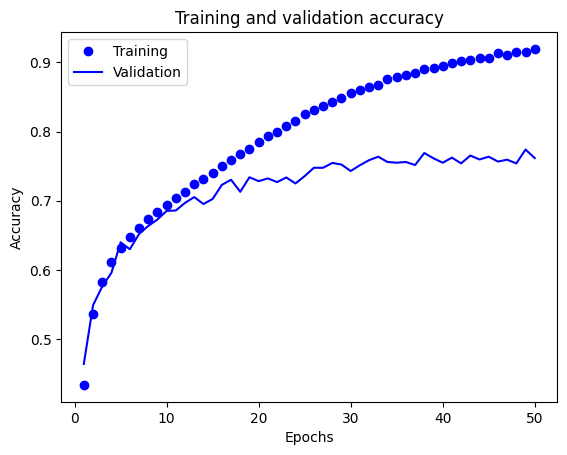

Optimal point:  17 epochs
94/94 [==============================] - 0s 2ms/step


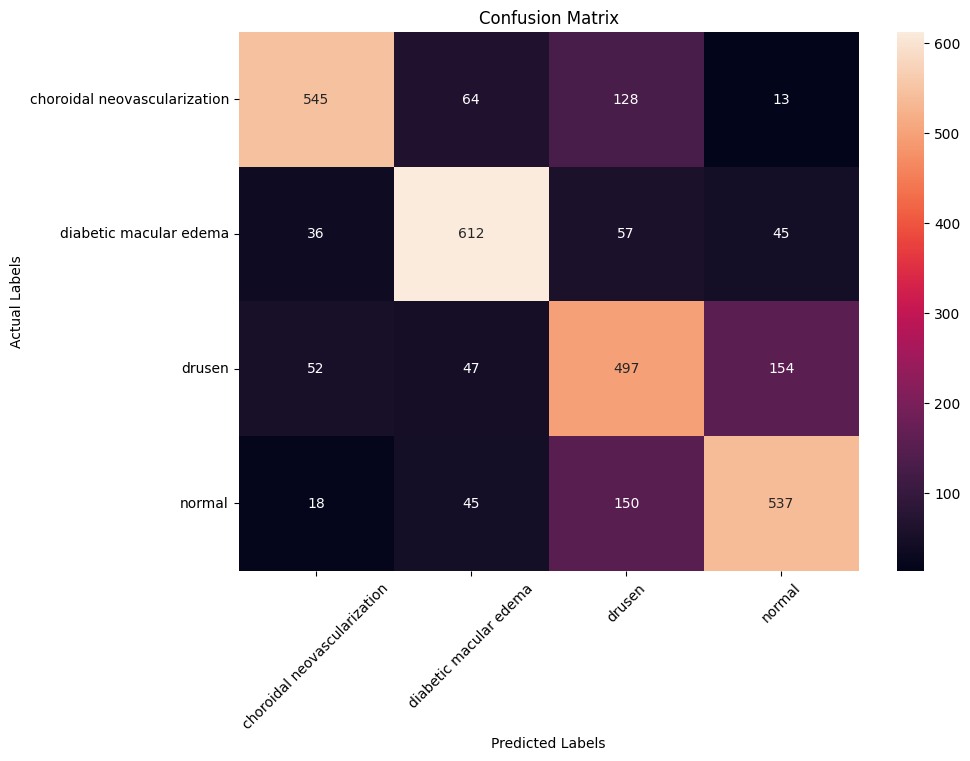

94/94 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.7303
Test accuracy: 0.7303333282470703


In [31]:
plot_network_summaries(history, 'best_model_B1-2.hdf5', val_images, val_labels)

The model overfits fairly quickly again, but provides a greater accuracy than the earlier models.

#### B3 - Decrease Layers

One of the dense layers is removed in order to evaluate the effect of simplification of the network.

In [22]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-3.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(1024, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=50, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/50
1575/1575 [==============================] - 18s 11ms/step - loss: 0.4071 - accuracy: 0.4427 - val_loss: 1.1304 - val_accuracy: 0.5063
Epoch 2/50
1575/1575 [==============================] - 16s 10ms/step - loss: 0.3539 - accuracy: 0.5386 - val_loss: 1.0639 - val_accuracy: 0.5520
Epoch 3/50
1575/1575 [==============================] - 17s 11ms/step - loss: 0.3306 - accuracy: 0.5791 - val_loss: 0.9754 - val_accuracy: 0.5973
Epoch 4/50
1575/1575 [==============================] - 17s 11ms/step - loss: 0.3135 - accuracy: 0.6064 - val_loss: 0.8839 - val_accuracy: 0.6387
Epoch 5/50
1575/1575 [==============================] - 16s 10ms/step - loss: 0.3022 - accuracy: 0.6255 - val_loss: 0.8857 - val_accuracy: 0.6363
Epoch 6/50
1575/1575 [==============================] - 16s 10ms/step - loss: 0.2921 - accuracy: 0.6402 - val_loss: 0.8513 - val_accuracy: 0.6487
Epoch 7/50
1575/1575 [==============================] - 16s 10ms/step - loss: 0.2843 - accuracy: 0.6516 - val_loss: 0.8336 -

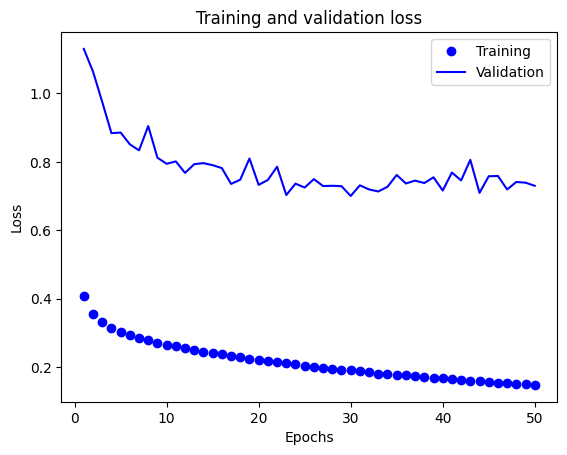

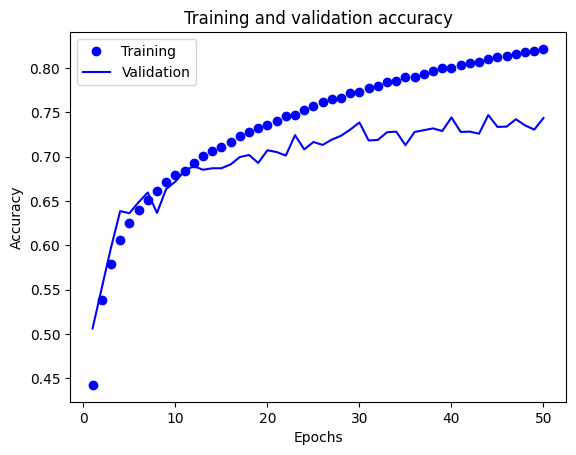

Optimal point:  30 epochs
94/94 [==============================] - 0s 2ms/step


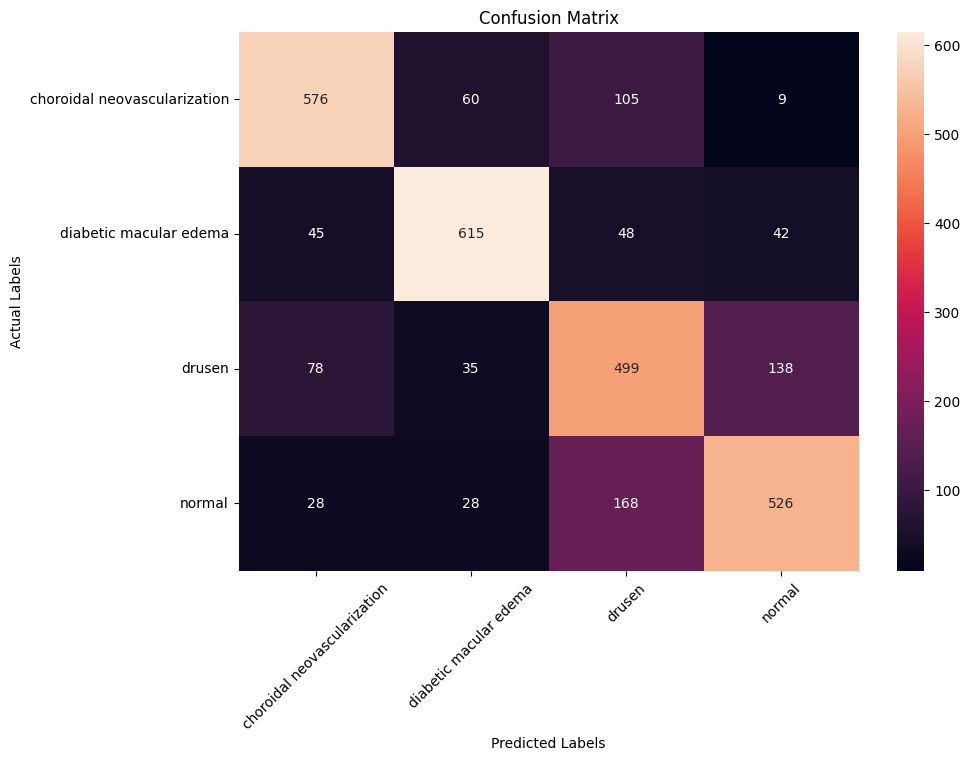

94/94 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.7387
Test accuracy: 0.7386666536331177


In [25]:
plot_network_summaries(history, 'best_model_B1-3.hdf5', val_images, val_labels)

The simplification resulted in some further accuracy gain, but also addresses some of the drastic overfitting of the earlier model.

#### B4 - Decreased Neurons

The Neurons is decreased from 1028 in each layer to 512

In [26]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-4.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=50, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/50
1575/1575 [==============================] - 9s 5ms/step - loss: 0.4072 - accuracy: 0.4440 - val_loss: 1.1974 - val_accuracy: 0.4847
Epoch 2/50
  12/1575 [..............................] - ETA: 7s - loss: 0.3676 - accuracy: 0.5286

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1575/1575 [==============================] - 7s 5ms/step - loss: 0.3534 - accuracy: 0.5436 - val_loss: 1.0586 - val_accuracy: 0.5437
Epoch 3/50
1575/1575 [==============================] - 7s 5ms/step - loss: 0.3293 - accuracy: 0.5822 - val_loss: 0.9676 - val_accuracy: 0.5963
Epoch 4/50
1575/1575 [==============================] - 7s 5ms/step - loss: 0.3132 - accuracy: 0.6078 - val_loss: 0.9127 - val_accuracy: 0.6180
Epoch 5/50
1575/1575 [==============================] - 7s 5ms/step - loss: 0.3017 - accuracy: 0.6233 - val_loss: 0.9337 - val_accuracy: 0.6217
Epoch 6/50
1575/1575 [==============================] - 8s 5ms/step - loss: 0.2919 - accuracy: 0.6396 - val_loss: 0.8527 - val_accuracy: 0.6567
Epoch 7/50
1575/1575 [==============================] - 7s 5ms/step - loss: 0.2846 - accuracy: 0.6499 - val_loss: 0.8622 - val_accuracy: 0.6450
Epoch 8/50
1575/1575 [==============================] - 8s 5ms/step - loss: 0.2773 - accuracy: 0.6627 - val_loss: 0.8470 - val_accuracy: 0.6463
Epo

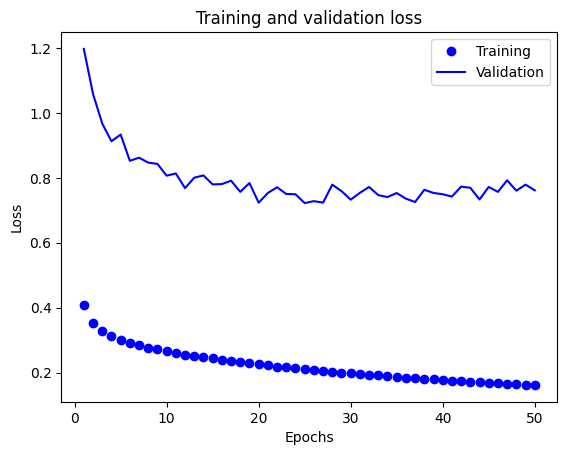

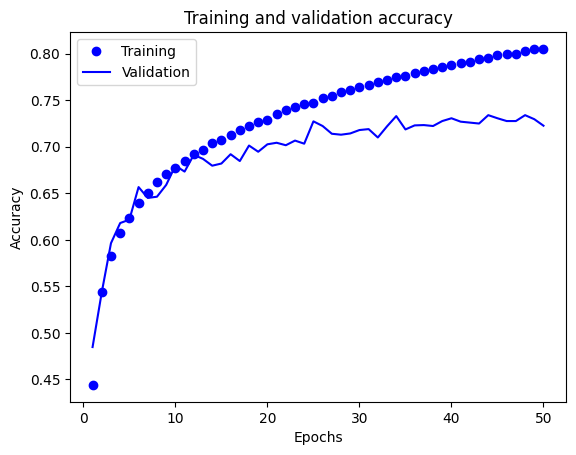

Optimal point:  25 epochs
94/94 [==============================] - 0s 2ms/step


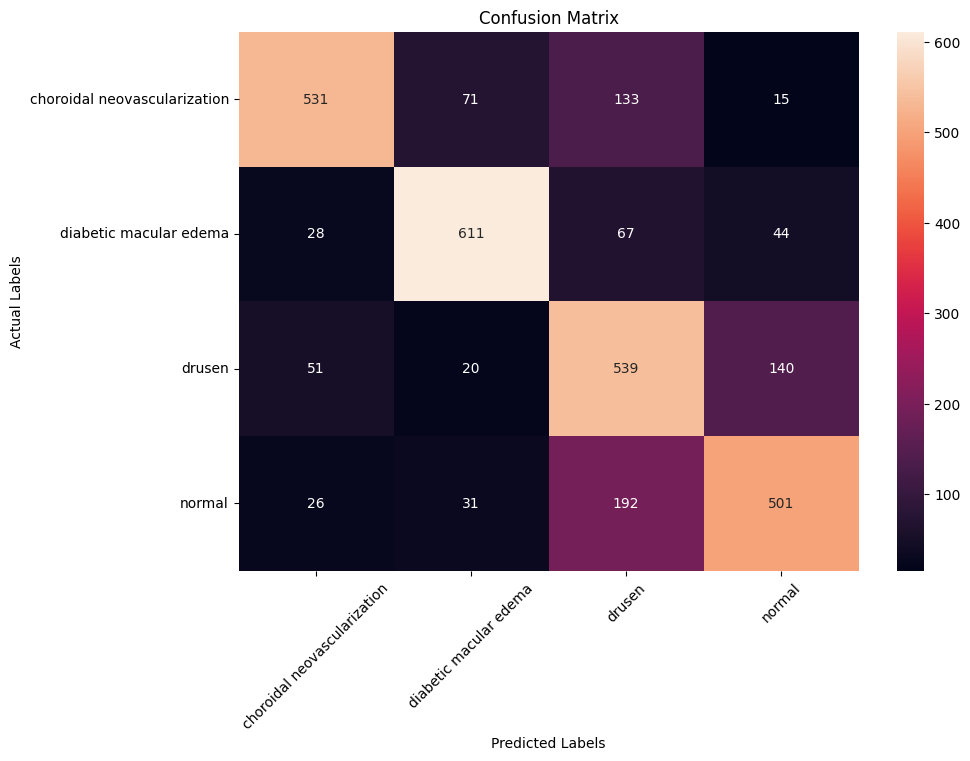

94/94 [==============================] - 0s 2ms/step - loss: 0.7224 - accuracy: 0.7273
Test accuracy: 0.7273333072662354


In [28]:
plot_network_summaries(history, 'best_model_B1-4.hdf5', val_images, val_labels)

The less complex network does have a decreased accuracy, but warrants some further experimentation.

#### B5 - Structure experimentation

Instead of a square structure, two layers, one of 1024, and one of 256 neurons is used.

In [29]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-5.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=50, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.4109 - accuracy: 0.4372 - val_loss: 1.2270 - val_accuracy: 0.4780
Epoch 2/50
  28/1575 [..............................] - ETA: 8s - loss: 0.3769 - accuracy: 0.5114

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1575/1575 [==============================] - 10s 6ms/step - loss: 0.3582 - accuracy: 0.5344 - val_loss: 1.0384 - val_accuracy: 0.5717
Epoch 3/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.3333 - accuracy: 0.5760 - val_loss: 0.9807 - val_accuracy: 0.5870
Epoch 4/50
1575/1575 [==============================] - 9s 6ms/step - loss: 0.3163 - accuracy: 0.6039 - val_loss: 0.9492 - val_accuracy: 0.5960
Epoch 5/50
1575/1575 [==============================] - 9s 6ms/step - loss: 0.3027 - accuracy: 0.6234 - val_loss: 0.9137 - val_accuracy: 0.6213
Epoch 6/50
1575/1575 [==============================] - 9s 6ms/step - loss: 0.2917 - accuracy: 0.6414 - val_loss: 0.8235 - val_accuracy: 0.6640
Epoch 7/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.2838 - accuracy: 0.6522 - val_loss: 0.8563 - val_accuracy: 0.6557
Epoch 8/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.2756 - accuracy: 0.6647 - val_loss: 0.7996 - val_accuracy: 0.6690

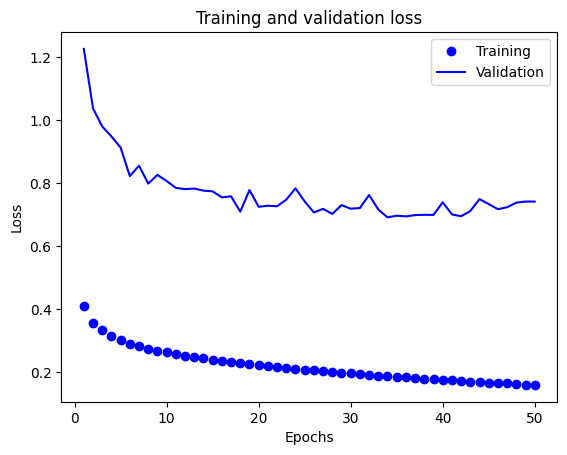

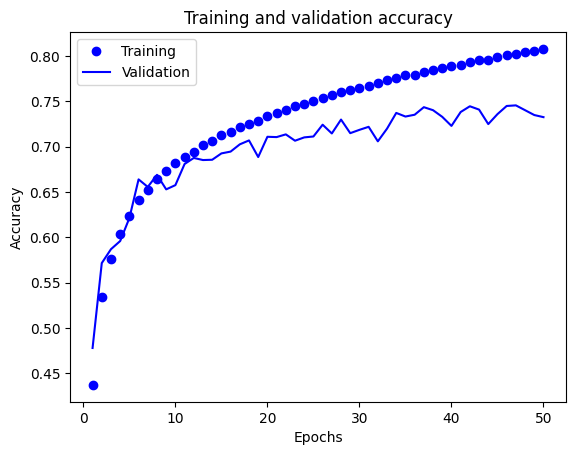

Optimal point:  34 epochs
94/94 [==============================] - 0s 2ms/step


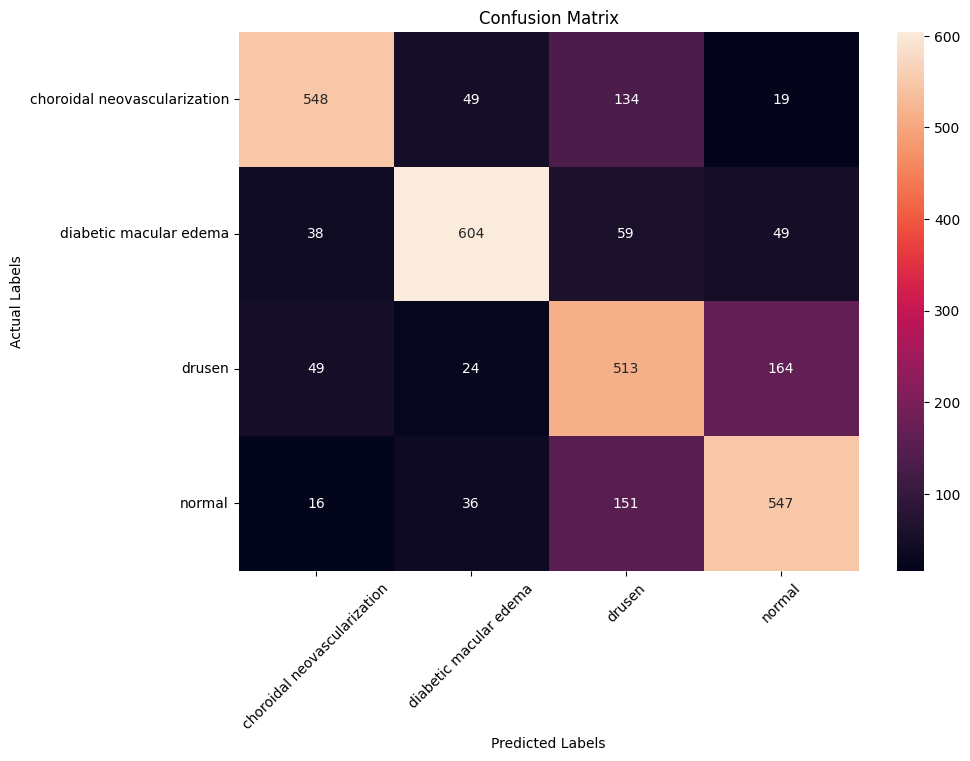

94/94 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.7373
Test accuracy: 0.737333357334137


In [30]:
plot_network_summaries(history, 'best_model_B1-5.hdf5', val_images, val_labels)

This network once again shows improvement, indicating that the first 1024 neuron dense layer may be important in the composition.

#### B6 - Further experimentation

The neurons of the second dense layer is decreased further.

In [31]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-6.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=50, batch_size=128, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.4124 - accuracy: 0.4338 - val_loss: 1.1469 - val_accuracy: 0.5033
Epoch 2/50
   1/1575 [..............................] - ETA: 9s - loss: 0.3376 - accuracy: 0.6094

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1575/1575 [==============================] - 10s 6ms/step - loss: 0.3593 - accuracy: 0.5346 - val_loss: 1.0447 - val_accuracy: 0.5587
Epoch 3/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.3343 - accuracy: 0.5786 - val_loss: 1.0391 - val_accuracy: 0.5573
Epoch 4/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.3176 - accuracy: 0.6048 - val_loss: 1.0037 - val_accuracy: 0.5840
Epoch 5/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.3054 - accuracy: 0.6231 - val_loss: 0.8744 - val_accuracy: 0.6350
Epoch 6/50
1575/1575 [==============================] - 9s 6ms/step - loss: 0.2964 - accuracy: 0.6382 - val_loss: 0.8871 - val_accuracy: 0.6433
Epoch 7/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.2884 - accuracy: 0.6473 - val_loss: 0.8537 - val_accuracy: 0.6490
Epoch 8/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.2812 - accuracy: 0.6590 - val_loss: 0.8397 - val_accuracy: 0.66

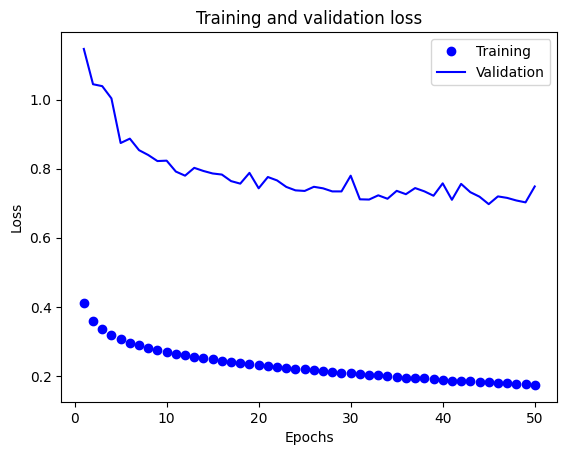

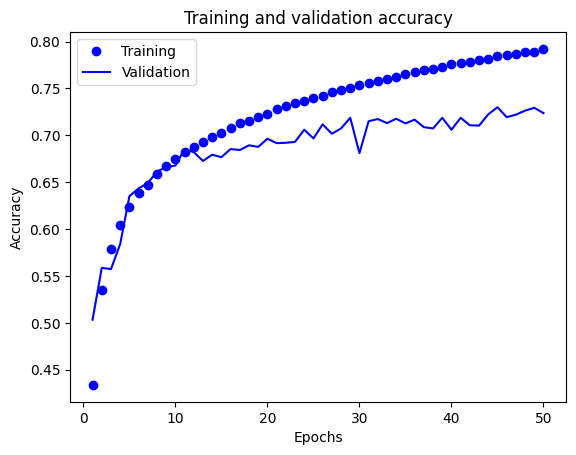

Optimal point:  45 epochs
94/94 [==============================] - 0s 1ms/step


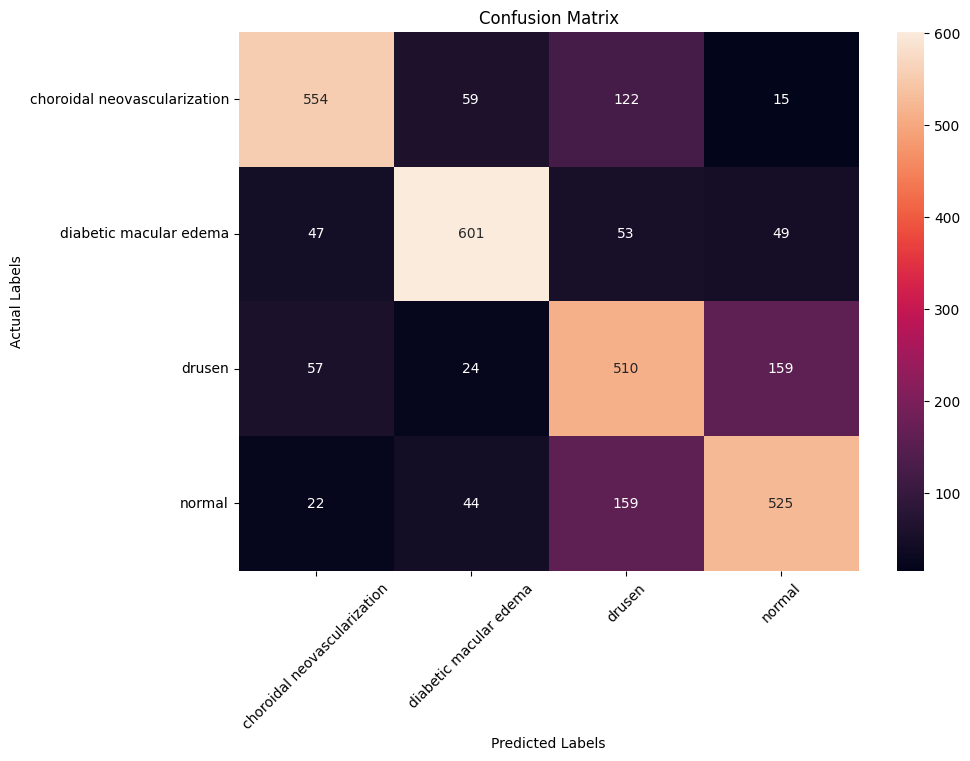

94/94 [==============================] - 0s 2ms/step - loss: 0.6973 - accuracy: 0.7300
Test accuracy: 0.7300000190734863


In [32]:
plot_network_summaries(history, 'best_model_B1-6.hdf5', val_images, val_labels)

The model has a bit less accuracy that the earlier model, but trains faster, and has a good distribution of confusion between the drusen and normal labels

#### B7 - Regularizer

A regularizer of 0.001 is added, and the epochs is increased in order to evaluate the effect.

In [37]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-7.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001), input_shape = (28*28, )))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=75, batch_size=512, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/75
394/394 [==============================] - 4s 8ms/step - loss: 0.5400 - accuracy: 0.3592 - val_loss: 1.4048 - val_accuracy: 0.3910
Epoch 2/75
394/394 [==============================] - 3s 8ms/step - loss: 0.4246 - accuracy: 0.4393 - val_loss: 1.2981 - val_accuracy: 0.4263
Epoch 3/75
394/394 [==============================] - 3s 8ms/step - loss: 0.4066 - accuracy: 0.4749 - val_loss: 1.2123 - val_accuracy: 0.4733
Epoch 4/75
394/394 [==============================] - 3s 8ms/step - loss: 0.3954 - accuracy: 0.4974 - val_loss: 1.2086 - val_accuracy: 0.4713
Epoch 5/75
394/394 [==============================] - 3s 8ms/step - loss: 0.3885 - accuracy: 0.5117 - val_loss: 1.1554 - val_accuracy: 0.5073
Epoch 6/75
394/394 [==============================] - 3s 8ms/step - loss: 0.3818 - accuracy: 0.5266 - val_loss: 1.1432 - val_accuracy: 0.5083
Epoch 7/75
394/394 [==============================] - 3s 8ms/step - loss: 0.3754 - accuracy: 0.5375 - val_loss: 1.1098 - val_accuracy: 0.5217
Epoch 

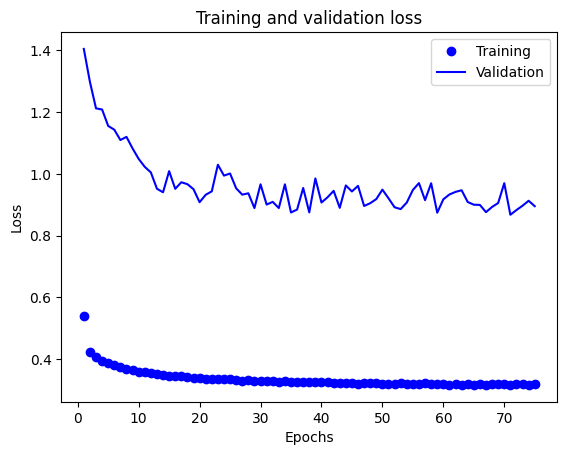

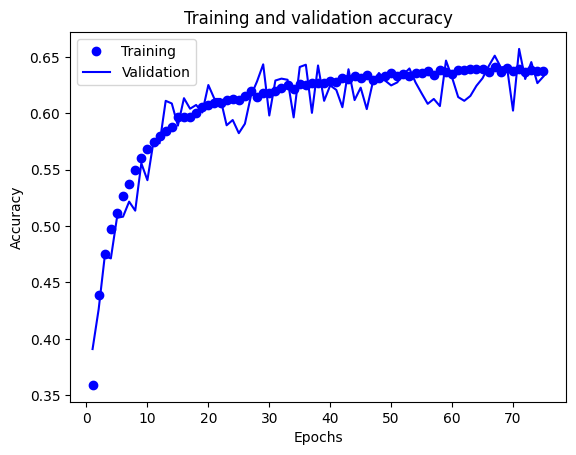

Optimal point:  71 epochs
94/94 [==============================] - 0s 2ms/step


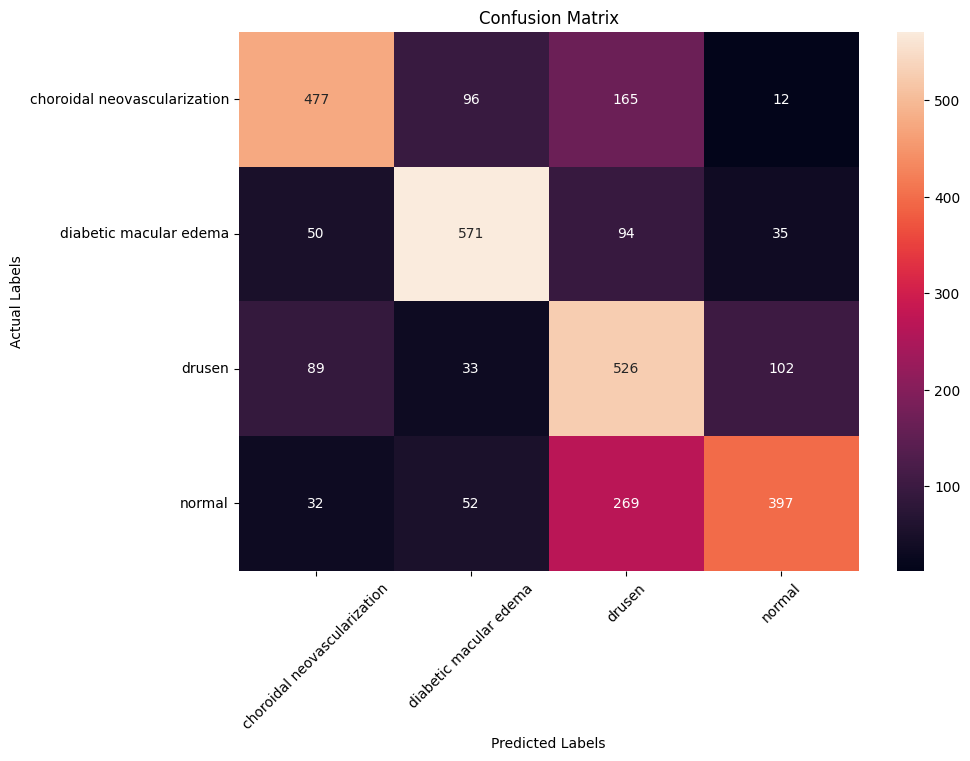

94/94 [==============================] - 0s 2ms/step - loss: 0.8677 - accuracy: 0.6570
Test accuracy: 0.6570000052452087


In [38]:
plot_network_summaries(history, 'best_model_B1-7.hdf5', val_images, val_labels)

The accuracy of the new model is much lower, while quickly exhausting the data in the training set.

#### B8 - Regularizer removed, epoch kept

The regularizer is removed, but a test is made with the increased epoch, to see if overfitting can be reached.

In [39]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-8.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=75, batch_size=512, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/75
394/394 [==============================] - 3s 8ms/step - loss: 0.4381 - accuracy: 0.3731 - val_loss: 1.2854 - val_accuracy: 0.4463
Epoch 2/75
 23/394 [>.............................] - ETA: 2s - loss: 0.4002 - accuracy: 0.4671

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 3s 8ms/step - loss: 0.3782 - accuracy: 0.5013 - val_loss: 1.1033 - val_accuracy: 0.5157
Epoch 3/75
394/394 [==============================] - 3s 8ms/step - loss: 0.3540 - accuracy: 0.5429 - val_loss: 1.0455 - val_accuracy: 0.5577
Epoch 4/75
394/394 [==============================] - 3s 7ms/step - loss: 0.3358 - accuracy: 0.5731 - val_loss: 1.0173 - val_accuracy: 0.5533
Epoch 5/75
394/394 [==============================] - 3s 7ms/step - loss: 0.3206 - accuracy: 0.5987 - val_loss: 0.9098 - val_accuracy: 0.6143
Epoch 6/75
394/394 [==============================] - 3s 7ms/step - loss: 0.3083 - accuracy: 0.6178 - val_loss: 0.9127 - val_accuracy: 0.6280
Epoch 7/75
394/394 [==============================] - 3s 7ms/step - loss: 0.3006 - accuracy: 0.6302 - val_loss: 0.8781 - val_accuracy: 0.6307
Epoch 8/75
394/394 [==============================] - 3s 7ms/step - loss: 0.2922 - accuracy: 0.6437 - val_loss: 0.8553 - val_accuracy: 0.6497
Epoch 9/75
394/39

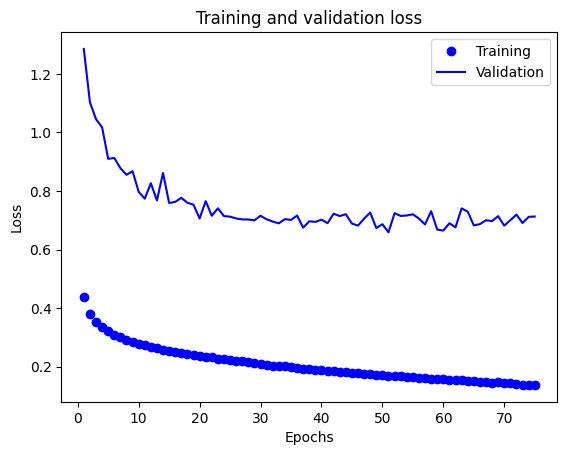

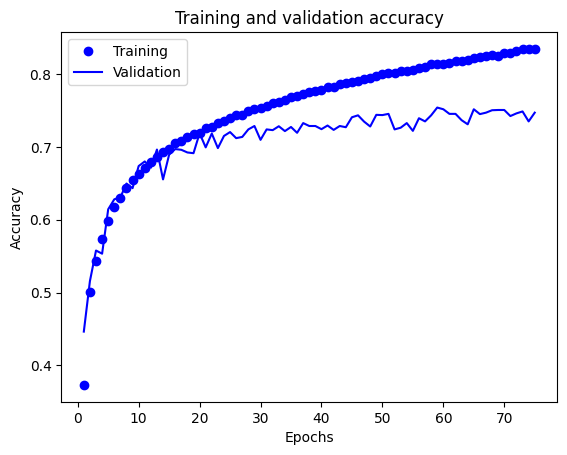

Optimal point:  51 epochs
94/94 [==============================] - 0s 2ms/step


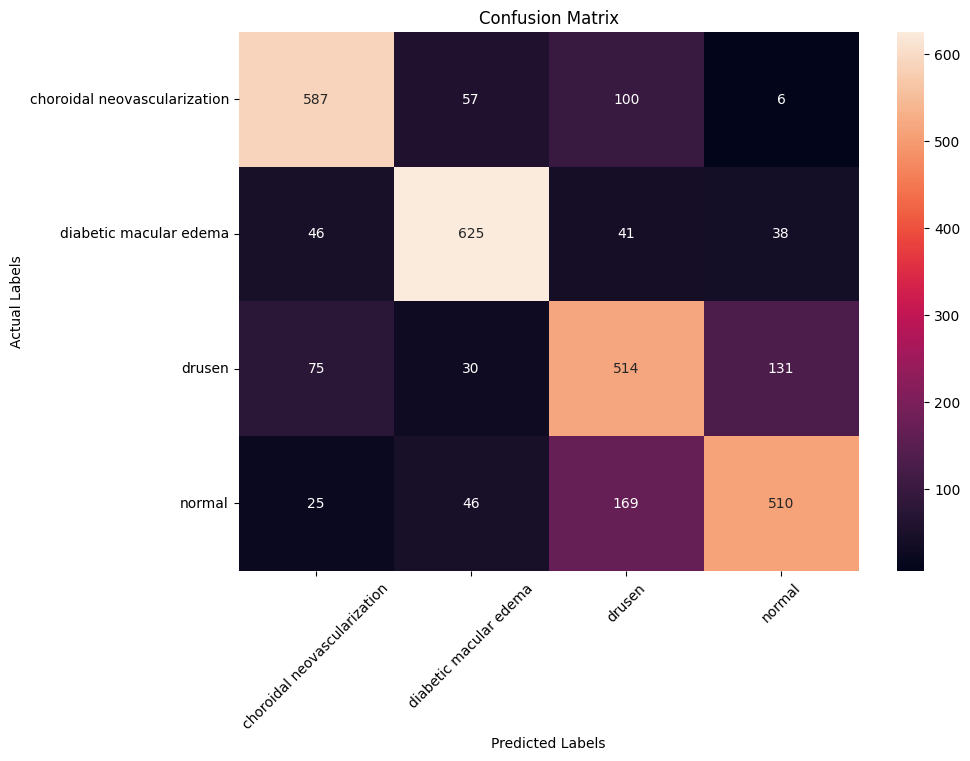

94/94 [==============================] - 0s 2ms/step - loss: 0.6588 - accuracy: 0.7453
Test accuracy: 0.7453333139419556


In [40]:
plot_network_summaries(history, 'best_model_B1-8.hdf5', val_images, val_labels)

Increasing the epochs further improved the accuracy, overfitting is still uncertain.

#### B9 - Further Epoch increase

Epochs is increased to 150 to ensure that the point of overfitting is reached.
Also experiment with bach size increase.

In [21]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-9.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=150, batch_size=1024, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/150
196/197 [============================>.] - ETA: 0s - loss: 0.4455 - accuracy: 0.3582

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 4s 15ms/step - loss: 0.4454 - accuracy: 0.3586 - val_loss: 1.3722 - val_accuracy: 0.4003
Epoch 2/150
197/197 [==============================] - 3s 14ms/step - loss: 0.3909 - accuracy: 0.4741 - val_loss: 1.2253 - val_accuracy: 0.4527
Epoch 3/150
197/197 [==============================] - 3s 14ms/step - loss: 0.3648 - accuracy: 0.5192 - val_loss: 1.1246 - val_accuracy: 0.5217
Epoch 4/150
197/197 [==============================] - 3s 17ms/step - loss: 0.3464 - accuracy: 0.5505 - val_loss: 1.0561 - val_accuracy: 0.5550
Epoch 5/150
197/197 [==============================] - 3s 13ms/step - loss: 0.3327 - accuracy: 0.5742 - val_loss: 1.0728 - val_accuracy: 0.5530
Epoch 6/150
197/197 [==============================] - 3s 15ms/step - loss: 0.3199 - accuracy: 0.5951 - val_loss: 1.0162 - val_accuracy: 0.5707
Epoch 7/150
197/197 [==============================] - 5s 26ms/step - loss: 0.3098 - accuracy: 0.6125 - val_loss: 1.0113 - val_accuracy: 0.6000
Epoc

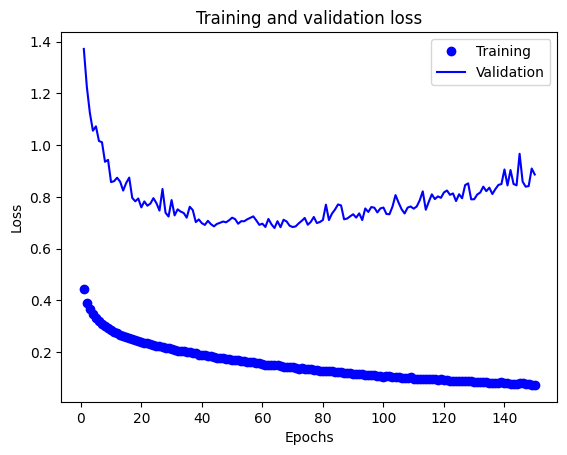

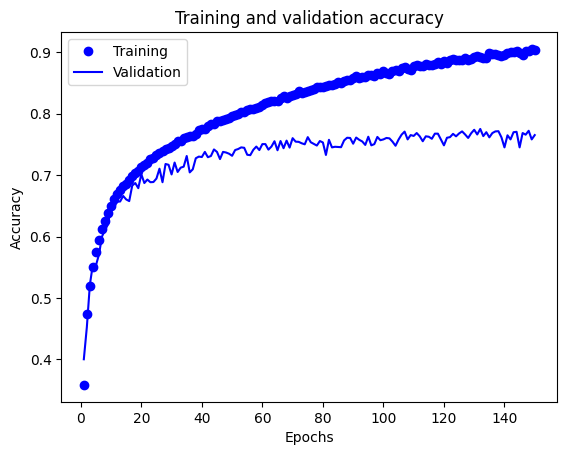

Optimal point:  64 epochs
94/94 [==============================] - 0s 2ms/step


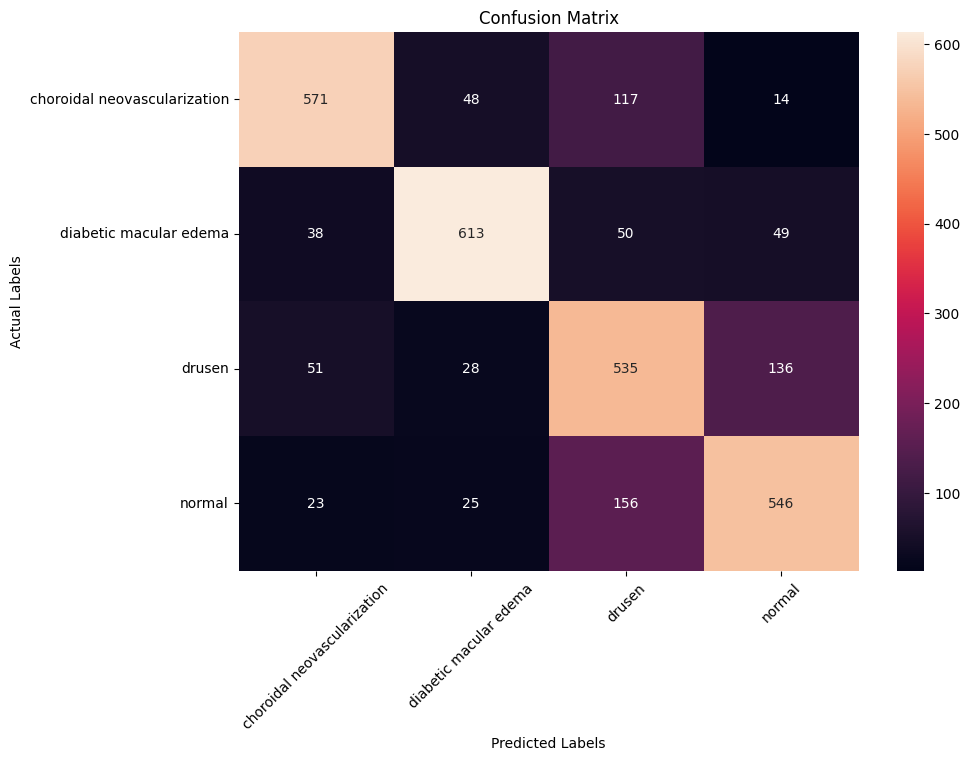

94/94 [==============================] - 0s 2ms/step - loss: 0.6797 - accuracy: 0.7550
Test accuracy: 0.7549999952316284


In [22]:
plot_network_summaries(history, 'best_model_B1-9.hdf5', val_images, val_labels)

The point of overfitting is determined to be reached at about 60 epochs, and have the loss increased afterward.

#### B10 - Smaller second dense layer

In [19]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-10.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=150, batch_size=512, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/150
394/394 [==============================] - 3s 7ms/step - loss: 0.4422 - accuracy: 0.3519 - val_loss: 1.2981 - val_accuracy: 0.4317
Epoch 2/150
394/394 [==============================] - 3s 7ms/step - loss: 0.3843 - accuracy: 0.4845 - val_loss: 1.1761 - val_accuracy: 0.4867
Epoch 3/150
394/394 [==============================] - 3s 7ms/step - loss: 0.3591 - accuracy: 0.5300 - val_loss: 1.0681 - val_accuracy: 0.5437
Epoch 4/150
394/394 [==============================] - 3s 7ms/step - loss: 0.3400 - accuracy: 0.5630 - val_loss: 1.0493 - val_accuracy: 0.5657
Epoch 5/150
394/394 [==============================] - 3s 6ms/step - loss: 0.3265 - accuracy: 0.5885 - val_loss: 1.0006 - val_accuracy: 0.5970
Epoch 6/150
394/394 [==============================] - 3s 6ms/step - loss: 0.3134 - accuracy: 0.6095 - val_loss: 0.9290 - val_accuracy: 0.6180
Epoch 7/150
394/394 [==============================] - 3s 7ms/step - loss: 0.3038 - accuracy: 0.6260 - val_loss: 0.8559 - val_accuracy: 0.6443

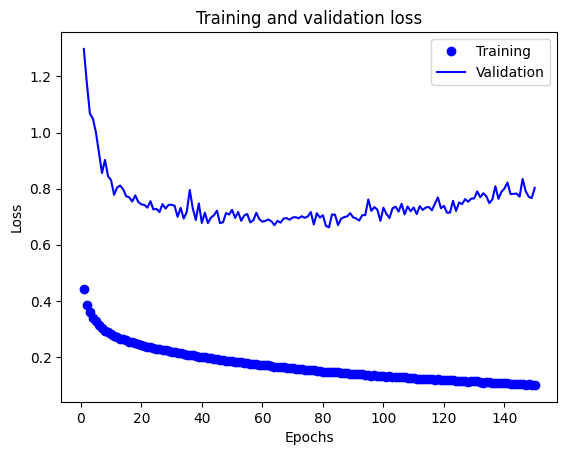

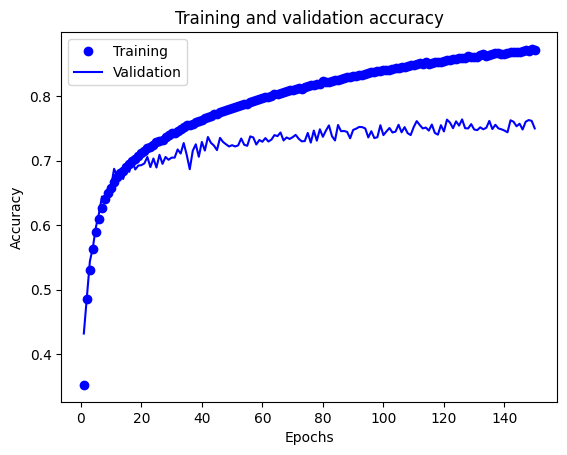

Optimal point:  82 epochs
94/94 [==============================] - 0s 1ms/step


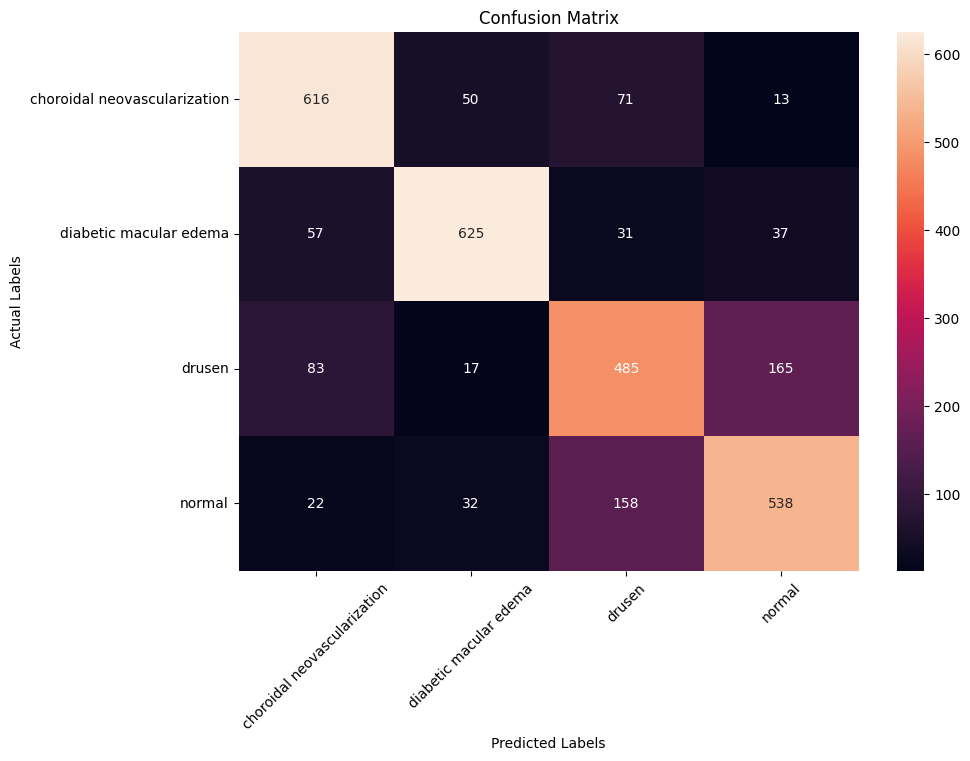

94/94 [==============================] - 0s 2ms/step - loss: 0.6620 - accuracy: 0.7547
Test accuracy: 0.7546666860580444


In [22]:
plot_network_summaries(history, 'best_model_B1-10.hdf5', val_images, val_labels)

The smaller amount of neurons, has a similar accuracy score, while training faster.

#### B11 - Batch size increase
Since the larger batch size increase positively affected the earlier model, the new model is also tested with it.

In [26]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

checkpoint = ModelCheckpoint(
    'best_model_B1-11.hdf5',
    monitor='val_loss',
    verbose=False,
    save_best_only=True,
    mode='min'
)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(train_images, train_labels, epochs=150, batch_size=1024, validation_data = (val_images, val_labels), class_weight=class_weight_dict, callbacks=[checkpoint])

Epoch 1/150
197/197 [==============================] - 3s 10ms/step - loss: 0.4496 - accuracy: 0.3371 - val_loss: 1.3282 - val_accuracy: 0.4097
Epoch 2/150
 12/197 [>.............................] - ETA: 1s - loss: 0.4092 - accuracy: 0.4402

c:\Projects\UoL\(DSM150-2023-OCT) Neural networks\CW1\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 2s 10ms/step - loss: 0.3982 - accuracy: 0.4615 - val_loss: 1.2907 - val_accuracy: 0.4553
Epoch 3/150
197/197 [==============================] - 2s 10ms/step - loss: 0.3742 - accuracy: 0.5052 - val_loss: 1.1159 - val_accuracy: 0.5167
Epoch 4/150
197/197 [==============================] - 2s 10ms/step - loss: 0.3561 - accuracy: 0.5335 - val_loss: 1.0750 - val_accuracy: 0.5423
Epoch 5/150
197/197 [==============================] - 2s 10ms/step - loss: 0.3439 - accuracy: 0.5555 - val_loss: 1.0541 - val_accuracy: 0.5577
Epoch 6/150
197/197 [==============================] - 2s 11ms/step - loss: 0.3322 - accuracy: 0.5751 - val_loss: 1.0225 - val_accuracy: 0.5753
Epoch 7/150
197/197 [==============================] - 2s 10ms/step - loss: 0.3201 - accuracy: 0.5949 - val_loss: 0.9586 - val_accuracy: 0.5980
Epoch 8/150
197/197 [==============================] - 2s 10ms/step - loss: 0.3110 - accuracy: 0.6124 - val_loss: 0.9731 - val_accuracy: 0.5923
Epoc

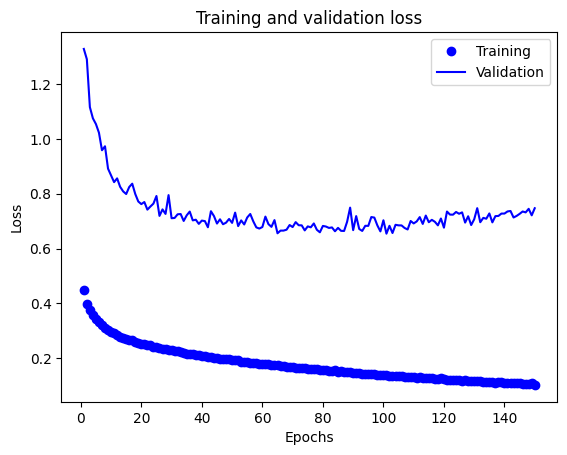

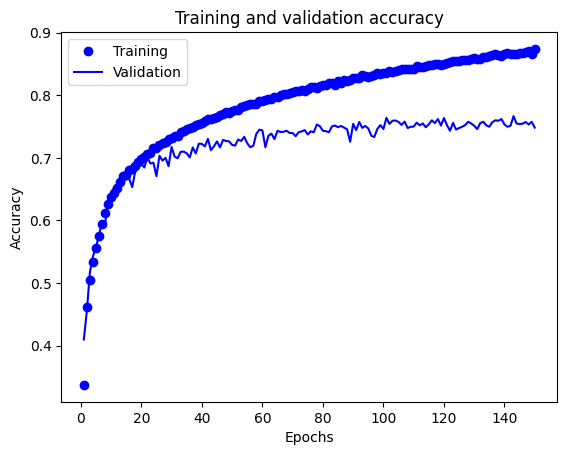

Optimal point:  101 epochs
94/94 [==============================] - 0s 1ms/step


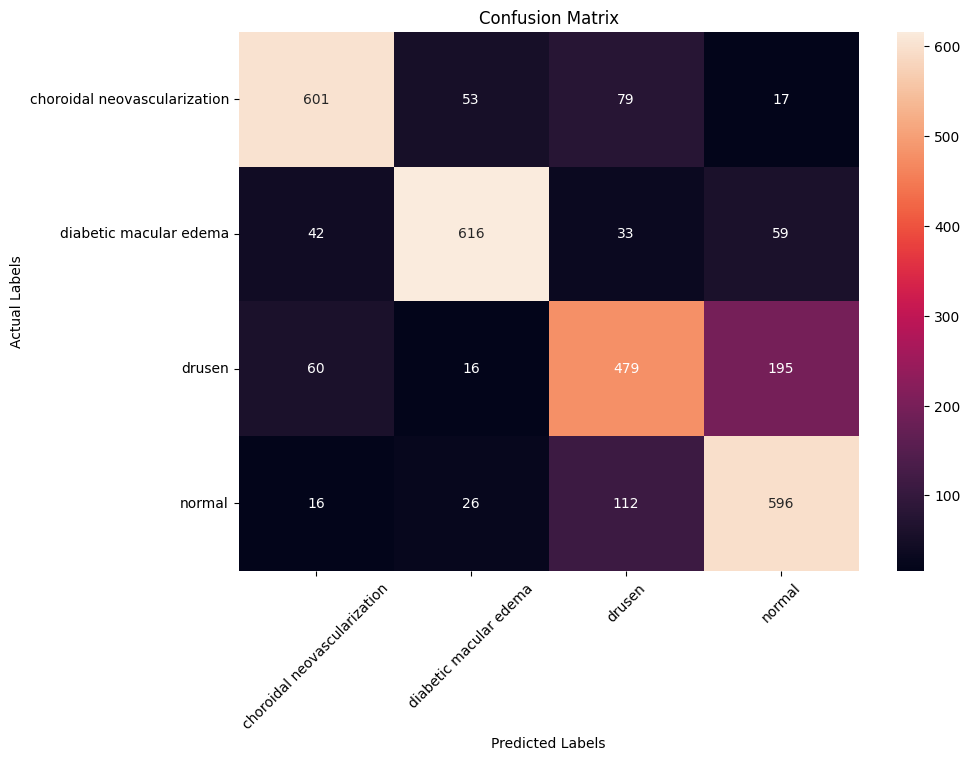

94/94 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.7640
Test accuracy: 0.7639999985694885


In [27]:
plot_network_summaries(history, 'best_model_B1-11.hdf5', val_images, val_labels)

This model is the best preforming overall reaching it's optimal point at 101 epochs

---

## Retraining on all training data

Training on the combined training and validation sets.

### Combining Datasets

In [25]:
combined_training_images = np.concatenate([train_images, val_images], axis=0)
combined_training_labels = np.concatenate([train_labels, val_labels.flatten()], axis=0)

### Training Network

After combining the network is trained on the full dataset as combined, for the target mount of epochs.

In [26]:
from tensorflow.keras import models, layers

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape = (28*28, )))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))

network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = network.fit(combined_training_images, combined_training_labels, epochs=101, batch_size=1024, class_weight=class_weight_dict)

Epoch 1/101
200/200 [==============================] - 3s 10ms/step - loss: 0.4547 - accuracy: 0.3179
Epoch 2/101
200/200 [==============================] - 2s 10ms/step - loss: 0.4069 - accuracy: 0.4273
Epoch 3/101
200/200 [==============================] - 2s 10ms/step - loss: 0.3790 - accuracy: 0.4833
Epoch 4/101
200/200 [==============================] - 2s 10ms/step - loss: 0.3587 - accuracy: 0.5232
Epoch 5/101
200/200 [==============================] - 2s 10ms/step - loss: 0.3451 - accuracy: 0.5480
Epoch 6/101
200/200 [==============================] - 2s 10ms/step - loss: 0.3305 - accuracy: 0.5724
Epoch 7/101
200/200 [==============================] - 2s 10ms/step - loss: 0.3204 - accuracy: 0.5919
Epoch 8/101
200/200 [==============================] - 2s 10ms/step - loss: 0.3087 - accuracy: 0.6104
Epoch 9/101
200/200 [==============================] - 2s 10ms/step - loss: 0.3013 - accuracy: 0.6228
Epoch 10/101
200/200 [==============================] - 2s 10ms/step - loss: 0.293

### Evaluate Final Model

 1/32 [..............................] - ETA: 1s

32/32 [==============================] - 0s 2ms/step


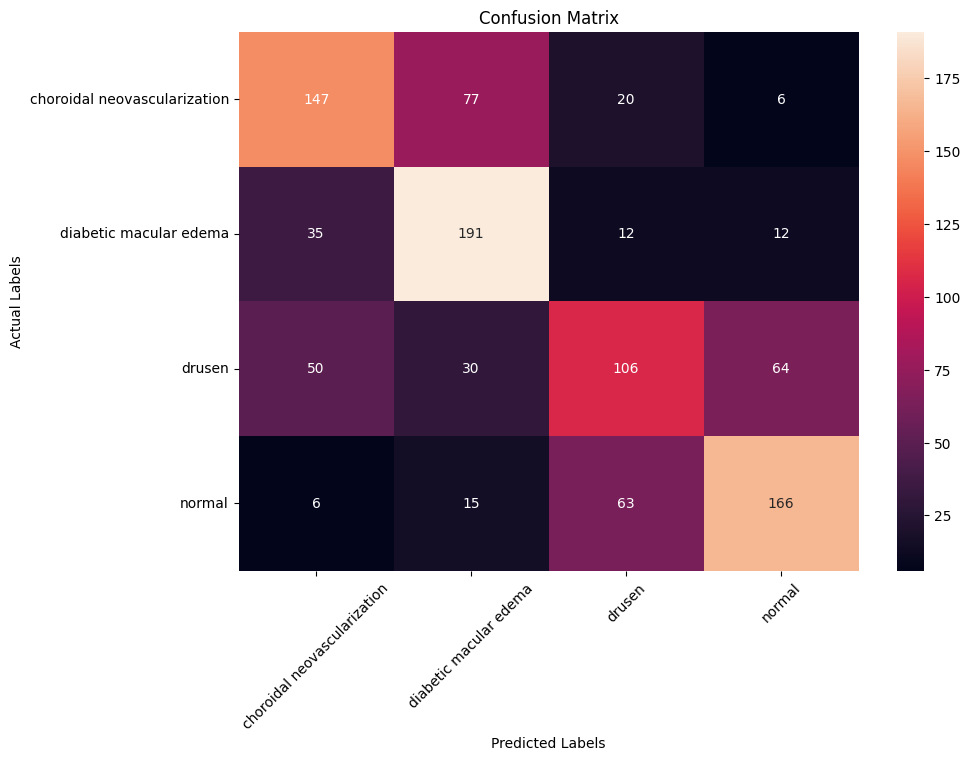

32/32 [==============================] - 0s 2ms/step - loss: 1.2294 - accuracy: 0.6100
Test accuracy: 0.6100000143051147


In [38]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

probabilities = network.predict(test_images.reshape((len(test_images), 28*28)))
predicted_classes = np.argmax(probabilities, axis=1)

# Generate the confusion matrix
labels = [info['label'][str(label)] for label in range(n_classes)]
cm = confusion_matrix(test_labels, predicted_classes.flatten())

# If you want to have a DataFrame representation
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.xticks(rotation=45)
plt.show()
    
test_loss, test_acc = network.evaluate(test_images.reshape((len(test_images), 28*28)), test_labels)
print('Test accuracy:', test_acc)

It unfortunately seems that the accuracy of the resulting network is much lower that the previous networks, which may indicate that the modeling of the network and hyperparameters may have be "overfit" to the validation data.